<a href="https://colab.research.google.com/github/MarinaWolters/Coding-Tracker/blob/master/Delta_Climate_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Delta Climate: Project Introduction**

Hi there! Welcome to Gail, Rekha, and Marina’s CIS-5450 Final Project.

In the course of this project, our focus will be on analyzing the patterns of surface temperature of both land and ocean on a global scale. Specifically, we will be investigating the temperature trends of various continents, countries, and cities. We will also look at the various events caused by rising temperatures by analysiing disaster tweets dataset and at countries' climate exposure by looking at economic, GDP, and population data via OECD datasets.

We start our analysis from Earth Surface Temperature, a publicly available dataset that was released by Berkeley. We will walk through the entire process by downloading and acquiring preliminary datasets, extracting features, conducting EDA, data modeling and time-series analysis.

#**Before we start**

This code will require the user to have data on their private Google drive. 
To run this notebook, please do the following:

1.   Click on this [link](https://drive.google.com/drive/folders/1GEHlk9lvzN8AAbWDUYP6vETUiP1abq9S?usp=share_link) to the project folder on Google Drive.
2. Right click the "CIS-545_Earth_Temperatures_Project", choose "MyDrive", and click "Add ShortCut" 
1.   After finishing the session, you may delete the "CIS-545_Earth_Temperatures_Project" folder from your Google Drive.

#**Step 1: Getting the Data**

To get the data:

1. Go to this Kaggle link and create a Kaggle account (unless you already have an account)
2. Go to Account and click on "Create New API Token" to get the API key in the form of a json file kaggle.json
3. Upload the kaggle.json file to the default location in your Google Drive



In [1]:
# Run this cell to mount your drive (you will be prompted to sign in)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!mkdir ~/.kaggle

In [4]:
# Read the uploaded kaggle.json file
!cp /content/drive/MyDrive/CIS-545_Earth_Temperatures_Project/Colab/kaggle.json ~/.kaggle/

In [5]:
# Download dataset
!!kaggle datasets download -d berkeleyearth/climate-change-earth-surface-temperature-data

['Downloading climate-change-earth-surface-temperature-data.zip to /content',
 '',
 '  0% 0.00/84.7M [00:00<?, ?B/s]',
 '  9% 8.00M/84.7M [00:00<00:00, 81.5MB/s]',
 ' 39% 33.0M/84.7M [00:00<00:00, 182MB/s] ',
 ' 60% 51.0M/84.7M [00:00<00:00, 121MB/s]',
 ' 79% 67.0M/84.7M [00:00<00:00, 133MB/s]',
 '',
 '100% 84.7M/84.7M [00:00<00:00, 147MB/s]']

In [6]:
# Unzip folder in Colab content folder
!unzip /content/climate-change-earth-surface-temperature-data.zip

Archive:  /content/climate-change-earth-surface-temperature-data.zip
  inflating: GlobalLandTemperaturesByCity.csv  
  inflating: GlobalLandTemperaturesByCountry.csv  
  inflating: GlobalLandTemperaturesByMajorCity.csv  
  inflating: GlobalLandTemperaturesByState.csv  
  inflating: GlobalTemperatures.csv  


In [7]:
# Import necessary libraries

import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split

In [8]:
# Read csv file and save it to a dataframe
df_temp_by_city = pd.read_csv("GlobalLandTemperaturesByCity.csv")
df_temp_by_country = pd.read_csv("GlobalLandTemperaturesByCountry.csv")
df_temp_by_major_city = pd.read_csv("GlobalLandTemperaturesByMajorCity.csv")
df_temp_by_state = pd.read_csv("GlobalLandTemperaturesByState.csv")
df_temp = pd.read_csv("GlobalTemperatures.csv")

#**Step 2: Data Exploration and Wrangling**

We are going to explore `df_temp_by_city` DF and look at the data types, number of cities, number of missing values, and number of countries.

In [9]:
df_temp_by_city.head(5)

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [10]:
# Data types
df_temp_by_city.dtypes

dt                                object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
City                              object
Country                           object
Latitude                          object
Longitude                         object
dtype: object

In [11]:
print("Total rows in temp_by_city df: ", len(df_temp_by_city))

Total rows in temp_by_city df:  8599212


In [12]:
# Check duplicate cities 
cities = df_temp_by_city.City.unique()
print("Unique cities in the dataframe: ", len(cities))
cities_from_temp_list = cities.tolist()

Unique cities in the dataframe:  3448


In [13]:
countries = df_temp_by_city.Country.unique()
print("Unique countries in the dataframe: ", len(countries))

Unique countries in the dataframe:  159


The number of rows with missing temperature data is less than 5% of total number of rows.


In [14]:
missing_temp_df = df_temp_by_city.loc[df_temp_by_city['AverageTemperature'].isna()]
missing_temp_df.head()
print("Total number of rows with missing temperature data: ",len(missing_temp_df))
print("Percentage of rows with missing temperature data: {:.2f}%".format(len(missing_temp_df) / len(df_temp_by_city) * 100))

Total number of rows with missing temperature data:  364130
Percentage of rows with missing temperature data: 4.23%


Next, we find all the cities with missing values and create a series to find the number of such cities. We conclude that almost every city has a few missing values.

Following that, we find the number of missing values per city, using groupby and storing the result in `cities_mv_summary`. Then, we calculate the percentage of missing values per city.

Finally, we print the report on cities with missing values at 8, 10, 12, 15, 18, and 20 percent to help us make the decision for the acceptable level missing values.

In [15]:
#from numpy.core.multiarray import inner
cities_missing_values = missing_temp_df.City.unique()
print("Cities with missing values:", len(cities_missing_values))

# new DF with the number missing values by City (dropped unnecessary columns)
cities_mv_summary = missing_temp_df.groupby(['City']).count().drop(columns=['Country','Latitude','Longitude']).reset_index()
cities_mv_summary = cities_mv_summary.sort_values(by = 'City',ascending=False) 
#cities_mv_summary.head()

# Create a new DF with count of total values per City from original DF 
cities_total_values = df_temp_by_city.groupby(['City']).count().drop(columns=['Country','Latitude','Longitude']).reset_index()
# Merge two DFs and add a column missing_Temp_percent to calculate percentage of missing values by City
cities_mv_total = cities_mv_summary.merge(cities_total_values,left_on= 'City',right_on= 'City', how ='inner')
#cities_mv_total.head()
cities_mv_total = cities_mv_total.assign(missing_temp_percent=lambda x: (x.dt_x/x.dt_y)*100)
cities_mv_total = cities_mv_total.sort_values(by = 'missing_temp_percent',ascending= False)
#cities_mv_total.head()

# Print a report on number of cities with missing Temperature Values > 8,10,12,15,17,20 percent
percent_list = [8,10,12,15,17,20]
for x in percent_list:
  cities_to_drop = cities_mv_total.loc[cities_mv_total['missing_temp_percent'] > x] 
  print("percent of Nan", x,":-number of cities to drop:",len(cities_to_drop))

Cities with missing values: 3323
percent of Nan 8 :-number of cities to drop: 746
percent of Nan 10 :-number of cities to drop: 391
percent of Nan 12 :-number of cities to drop: 314
percent of Nan 15 :-number of cities to drop: 184
percent of Nan 17 :-number of cities to drop: 170
percent of Nan 20 :-number of cities to drop: 18


In [16]:
# Making the decision to drop missing value > 12 percent
cities_to_drop = cities_mv_total.loc[cities_mv_total['missing_temp_percent'] > 12] 
cities_to_drop.head()

,City,dt_x,AverageTemperature_x,AverageTemperatureUncertainty_x,dt_y,AverageTemperature_y,AverageTemperatureUncertainty_y,missing_temp_percent
1013,Port Louis,1039,0,0,2721,1682,1682,38.184491
807,Saint Denis,1039,0,0,2721,1682,1682,38.184491
2438,Fianarantsoa,1036,0,0,2721,1685,1685,38.074237
1369,Nacala,958,0,0,2721,1763,1763,35.207644
3197,Antananarivo,958,0,0,2721,1763,1763,35.207644


[Text(0.5, 1.0, 'Total # of Cities vs # of Cities with missing values vs # of Cities we dropped')]

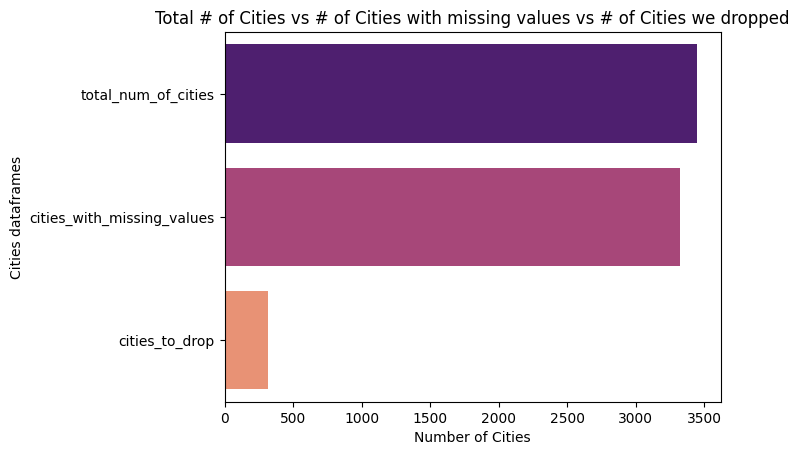

In [139]:
# Visualising out findings from analysis of missing values
d = {'total_num_of_cities': len(cities), 
     'cities_with_missing_values': len(cities_missing_values), 
     'cities_to_drop': len(cities_to_drop)}
vis_df = pd.DataFrame(d, index=list(range(0, 1)))

g = sns.barplot(data=vis_df, palette='magma', orient='h')
g.set(xlabel='Number of Cities', ylabel='Cities dataframes')
g.set(title="Total # of Cities vs # of Cities with missing values vs # of Cities we dropped")

As we can see, we can drop cities with >12% missing values and lose less than 10% of the cities. 

The guidelines for missing values in Metereology recommends not using months with greater than 3 consecutive days or 5 days in total for computing monthly averages.
https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/joc.5801

As an approximation to this rule, we drop cities with more than 12% of missing data. These rows have been flagged below.


In [18]:
cities_to_drop_list = cities_to_drop['City'].tolist()

df_temp_by_city['drop_city'] = df_temp_by_city['City'].apply(lambda x: 1 if x in cities_to_drop_list else 0)
df_temp_by_city.head()
df_temp_by_city.tail()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,drop_city
8599207,2013-05-01,11.464,0.236,Zwolle,Netherlands,52.24N,5.26E,0
8599208,2013-06-01,15.043,0.261,Zwolle,Netherlands,52.24N,5.26E,0
8599209,2013-07-01,18.775,0.193,Zwolle,Netherlands,52.24N,5.26E,0
8599210,2013-08-01,18.025,0.298,Zwolle,Netherlands,52.24N,5.26E,0
8599211,2013-09-01,NaN,NaN,Zwolle,Netherlands,52.24N,5.26E,0


## 2.1 Temperature dataset 

Going back to the original temperature dataset, less than 5% of the data has missing values. Therefore, we just remove the nulls.

We also do the following:
1. Check duplicate values
2. To simplify analysis, drop unnecessary columns
3. To allow timeseries, convert dt type from object to datetime
4. Explore the data through visualization



In [19]:
# There is no change in the number of rows after calling drop_duplicates(). Therefore, there is no need to drop duplicates.
len(df_temp_by_city) - len(df_temp_by_city.drop_duplicates())

0

In [20]:
# Number of missing values is still 364,140
df_temp_by_city.isna().sum()

dt                                    0
AverageTemperature               364130
AverageTemperatureUncertainty    364130
City                                  0
Country                               0
Latitude                              0
Longitude                             0
drop_city                             0
dtype: int64

In [21]:
# Drop null values
df_temp_by_city_clean = df_temp_by_city.dropna().reset_index(drop = True)

# Number of missing values is now zero
df_temp_by_city_clean.isna().sum()

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
City                             0
Country                          0
Latitude                         0
Longitude                        0
drop_city                        0
dtype: int64

In [22]:
# Cast dt as datetime
df_temp_by_city_clean['date'] =  pd.to_datetime(df_temp_by_city_clean['dt'], format='%Y-%m-%d')

# Drop columns
df_temp_by_city_clean = df_temp_by_city_clean.drop(columns=['dt'])

# Check distribution of average temperature
df_temp_by_city_clean['AverageTemperature'].describe()

count    8.235082e+06
mean     1.672743e+01
std      1.035344e+01
min     -4.270400e+01
25%      1.029900e+01
50%      1.883100e+01
75%      2.521000e+01
max      3.965100e+01
Name: AverageTemperature, dtype: float64

In [23]:
# Check unique values
print("There are", len(df_temp_by_city_clean['Country'].unique()), "unique countries in the dataset.")

There are 159 unique countries in the dataset.


We are interested in seeing the temperature in the countries throughout time. However, since there are too many countries (159 unique countries) in the dataset, we group them according to their continent and subregion.

To do this, we get another dataset that maps countries to continents and subregion.

In [24]:
# Read the uploaded kaggle.json file
!cp /content/drive/MyDrive/CIS-545_Earth_Temperatures_Project/Colab/kaggle.json ~/.kaggle/
# Download dataset
!!kaggle datasets download -d statchaitya/country-to-continent

['Downloading country-to-continent.zip to /content',
 '',
 '  0% 0.00/4.87k [00:00<?, ?B/s]',
 '',
 '100% 4.87k/4.87k [00:00<00:00, 8.91MB/s]']

In [25]:
# Unzip folder in Colab content folder
!unzip /content/country-to-continent.zip

Archive:  /content/country-to-continent.zip
  inflating: countryContinent.csv    


In [26]:
# Read the dataset and remove unnecessary columns
df_country_continent = pd.read_csv("countryContinent.csv" , encoding='ISO-8859-1')
df_country_continent_clean = df_country_continent[['country', 'code_2', 'code_3', 'continent', 'sub_region']]

In [27]:
# Look at the new df
df_temp_by_city_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8235082 entries, 0 to 8235081
Data columns (total 8 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   AverageTemperature             float64       
 1   AverageTemperatureUncertainty  float64       
 2   City                           object        
 3   Country                        object        
 4   Latitude                       object        
 5   Longitude                      object        
 6   drop_city                      int64         
 7   date                           datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 502.6+ MB


In [28]:
# Merge temperature dataset with continent dataset using left outer join to ensure that we keep all countries
df_temp_by_continent = df_temp_by_city_clean.merge(df_country_continent_clean, how = 'left', left_on = 'Country', right_on = 'country', indicator = 'True')
df_temp_by_continent.head()

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,drop_city,date,country,code_2,code_3,continent,sub_region,True
0,6.068,1.737,Århus,Denmark,57.05N,10.33E,0,1743-11-01,Denmark,DK,DNK,Europe,Northern Europe,both
1,5.788,3.624,Århus,Denmark,57.05N,10.33E,0,1744-04-01,Denmark,DK,DNK,Europe,Northern Europe,both
2,10.644,1.283,Århus,Denmark,57.05N,10.33E,0,1744-05-01,Denmark,DK,DNK,Europe,Northern Europe,both
3,14.051,1.347,Århus,Denmark,57.05N,10.33E,0,1744-06-01,Denmark,DK,DNK,Europe,Northern Europe,both
4,16.082,1.396,Århus,Denmark,57.05N,10.33E,0,1744-07-01,Denmark,DK,DNK,Europe,Northern Europe,both


In [29]:
# Check countries that did not merge and fix
array_countries_to_fix = df_temp_by_continent[df_temp_by_continent['True'] != 'both']['Country'].unique()
array_countries_to_fix

array(['Iran', 'Russia', "Côte D'Ivoire", 'United Kingdom',
       'United States', 'Venezuela', 'Burma', 'Syria', 'Tanzania',
       'Vietnam', 'Moldova', 'Congo (Democratic Republic Of The)',
       'Bosnia And Herzegovina', 'Guinea Bissau', 'Taiwan', 'Bolivia',
       'Macedonia', 'Reunion', 'South Korea', 'Laos'], dtype=object)

In [30]:
df_list = []
list_countries_to_fix = []
for country in array_countries_to_fix:

  df = df_country_continent[df_country_continent['country'].str.contains(country, regex = False)].head(1)

  if len(df) > 0: # if there is a match, append to list of dfs
    df['country2'] = country
    df_list.append(df)

  if len(df) == 0: # if there is no match, extract the key word (-1 index is the country name for single word countries; -1 is the last key word like "Korea" in South Korea) and match
    word = country.split(' ')[-1]
    df2 = df_country_continent[df_country_continent['country'].str.contains(word, regex = False)].head(1)
    
    df2['country2'] = country
    df_list.append(df2)
    
    if len(df2) == 0: # if there is no match, extract the first word for multi-word countries
      first_word = country.split(' ')[0]
      df3 = df_country_continent[df_country_continent['country'].str.contains(first_word, regex = False)].head(1)
      
      df3['country2'] = country
      df_list.append(df3)
      
      if len(df3) == 0: # if there is no match, extract the first few characters
        
        first_three_chars = first_word[0:4]
        df4 = df_country_continent[df_country_continent['country'].str.contains(first_three_chars, regex = False)].head(1)
        
        df4['country2'] = country
        df_list.append(df4)
        
        if len(df4) == 0:
          list_countries_to_fix.append(country)

df_country_continent_new1 = pd.concat(df_list)
print(list_countries_to_fix)

['Burma', 'Reunion', 'Laos']


We still have 3 countries that did not match. 
*   Burma is called Myanmar.
*   Reunion has special character Réunion.
* Laos is called Lao.

We further fix these country entries.

In [31]:
df_list = []
for country in list_countries_to_fix:
  if country == "Burma":
    df = df_country_continent[df_country_continent['country'].str.contains("Myanmar", regex = False)].head(1)
    df['country2'] = country
    df_list.append(df)

  if country == "Laos":
    df = df_country_continent[df_country_continent['country'].str.contains("Lao", regex = False)].head(1)
    df['country2'] = country
    df_list.append(df)

  if country == "Reunion":
    df = df_country_continent[df_country_continent['country'].str.contains("Réunion", regex = False)].head(1)
    df['country2'] = country
    df_list.append(df)

df_country_continent_new2 = pd.concat(df_list)

df_country_continent_new = pd.concat([df_country_continent_new1, df_country_continent_new2])

In [32]:
# Drop the redundant columns and append to the old df
df_country_continent_new = df_country_continent_new.drop(columns = ['country'])

df_country_continent_new = df_country_continent_new.rename(columns={'country2':'country'})

df_country_continent_new = pd.concat([df_country_continent, df_country_continent_new], axis=0)

Now that we fixed the mismatched countries. We go back to merging with the temperature dataset.

In [33]:
# Merge temperature dataset with continent dataset and check that number of rows is the same as df_temp_by_city_clean
df_temp_by_continent = df_temp_by_city_clean.merge(df_country_continent_new, how = 'inner', left_on = 'Country', right_on = 'country')
df_temp_by_continent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8235082 entries, 0 to 8235081
Data columns (total 17 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   AverageTemperature             float64       
 1   AverageTemperatureUncertainty  float64       
 2   City                           object        
 3   Country                        object        
 4   Latitude                       object        
 5   Longitude                      object        
 6   drop_city                      int64         
 7   date                           datetime64[ns]
 8   country                        object        
 9   code_2                         object        
 10  code_3                         object        
 11  country_code                   int64         
 12  iso_3166_2                     object        
 13  continent                      object        
 14  sub_region                     object        
 15  region_code    

Now, we can group by continents or subregion and visualize the temperature throughout the years.

In [34]:
# To visualize temperature over time in different continents
df_temp_by_continent_graph = df_temp_by_continent.groupby([df_temp_by_continent['date'].dt.year, 'continent'])['AverageTemperature'].agg(['mean', 'min', 'max']).reset_index()
df_temp_by_continent_graph.head()

,date,continent,mean,min,max
0,1743,Africa,14.721000,14.721,14.721
1,1743,Americas,4.972491,-5.240,18.722
2,1743,Asia,8.825923,6.176,11.478
3,1743,Europe,4.724352,-11.087,15.154
4,1744,Africa,19.658875,11.108,27.371


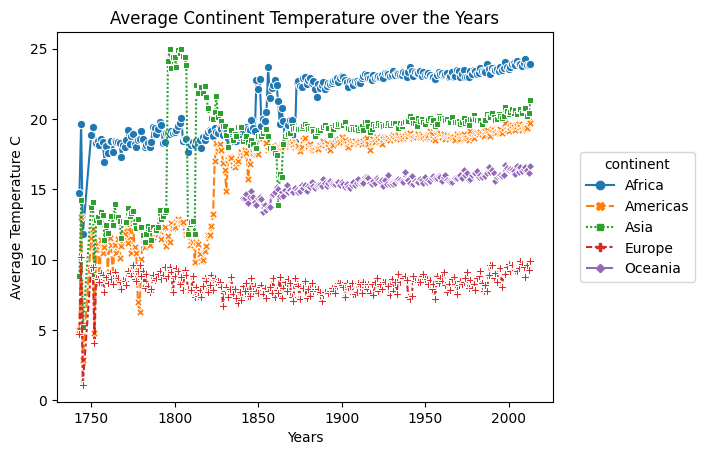

In [35]:
# Plot average continent's temperature over the years
g = sns.lineplot(data=df_temp_by_continent_graph, x='date', y='mean', hue='continent', style='continent', markers=True)
g.set(xlabel = "Years", ylabel = "Average Temperature C", title = "Average Continent Temperature over the Years")
sns.move_legend(g, "right", bbox_to_anchor=(1.3,0.5))
plt.show()

Based on the graph, we see that Africa has the highest average temperatures in the majority of the years, especially during recent times (1875 to 2013), with Asia coming in second. 

Americas and Oceania have the third and fourth highest average temperatures throughout the years, respectively, with Oceania data starting 100 years after the initial data point in the 1750s. 

Based on the graph, the temperatures of these four continents seem to have a linear relationship with time (1875 onwards) as they seem to increase as years go by.

Finally, Europe has the lowest average temperature among continents. The upward (or downward) trend is not as apparent as in other continents. 

![](https://drive.google.com/uc?export=view&id=1VyQK8Gs9Q14DW2N0AMU8qgboccGFSRCJ)

Source: https://en.wikipedia.org/wiki/Continent

Next, we are interested to see if there are differences between subregions within the continents.

In [36]:
# Group by year, continents, and subregion
df_temp_by_subregion = df_temp_by_continent.groupby([df_temp_by_continent['date'].dt.year, 'continent', 'sub_region'])['AverageTemperature'].agg(['mean', 'min', 'max']).reset_index()
array_continents = sorted(df_temp_by_continent['continent'].unique())

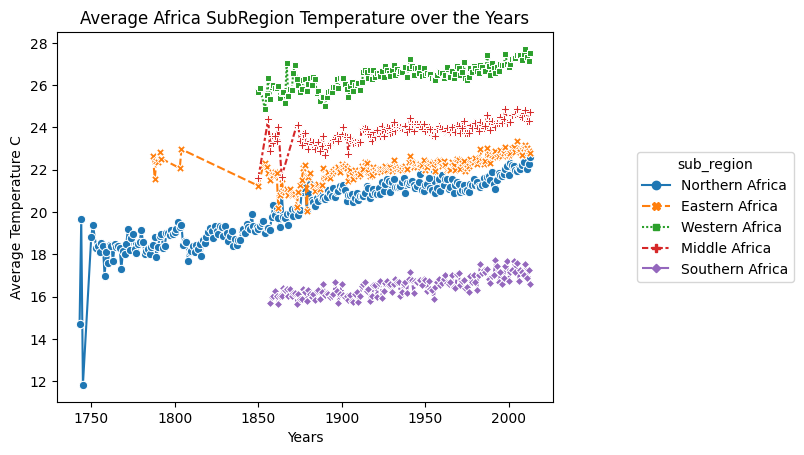

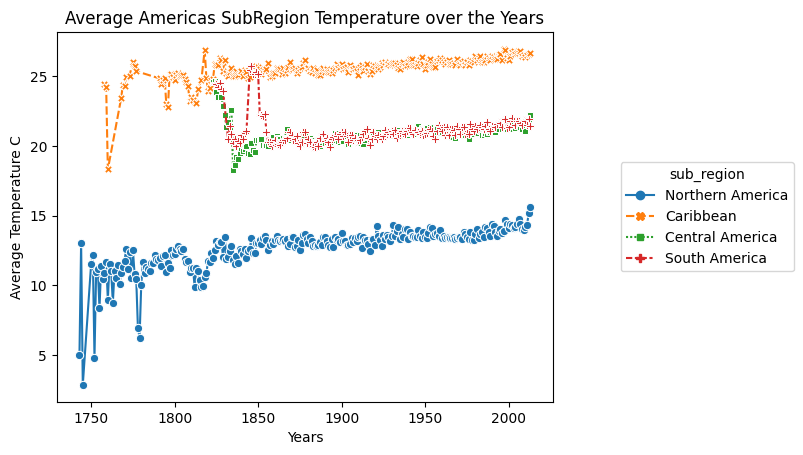

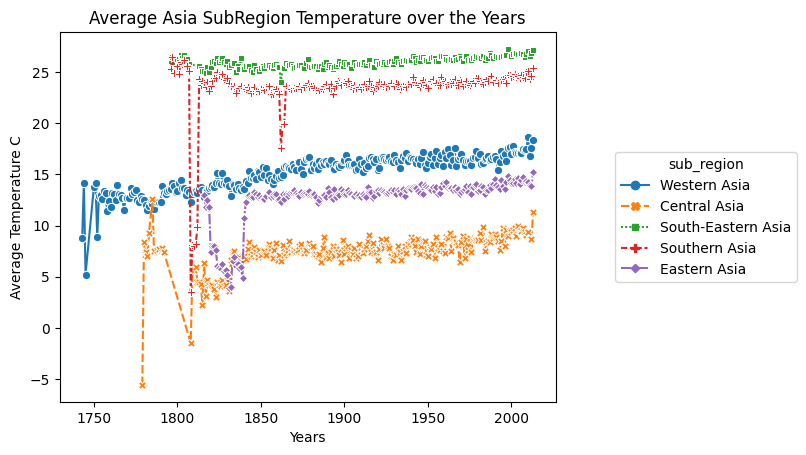

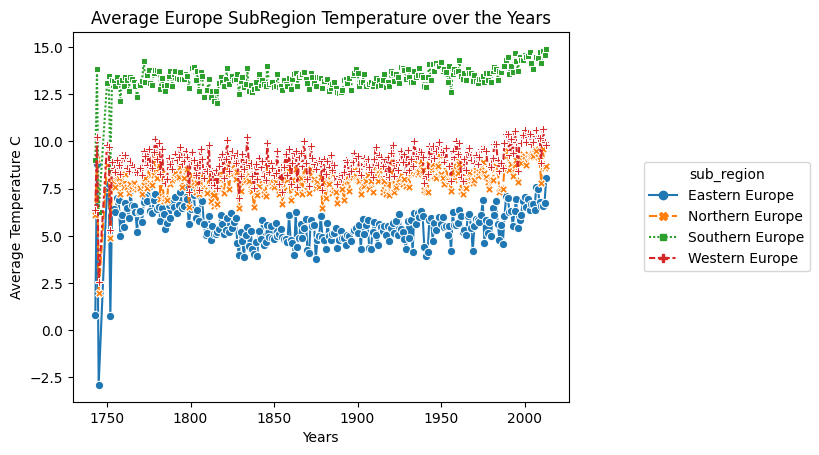

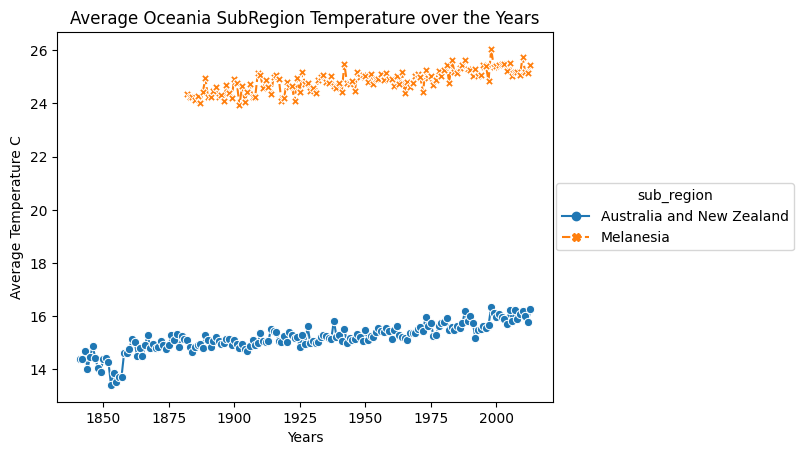

In [37]:
for continent in array_continents:
  df2 = df_temp_by_subregion[df_temp_by_subregion['continent'] == continent]
  plt.figure()
  g = sns.lineplot(data=df2, x='date', y='mean', hue='sub_region', style='sub_region', markers=True)
  sns.move_legend(g, "right", bbox_to_anchor=(1.5,0.5))
  g.set(xlabel = "Years", ylabel = "Average Temperature C", title = "Average " + continent + " SubRegion Temperature over the Years")

For Africa, we see that initial data (1750 to 1850) was only collected for North Africa. From 1850 onwards, we see the following order of temperature in subregions throughout the years from highest to lowest - Western, Middle, Eastern, Northern, and Southern. As Africa has temperature ranges from 20C above, the temperature of the Southern subregion seems to be at the lower end (~16C).

![](https://drive.google.com/uc?export=view&id=11Lq4ngtS62IJSX7oYGjqv6_WaH1oVg5x)
Source: https://en.wikipedia.org/wiki/List_of_regions_of_Africa

For Americas, we notice that the initial data (1750 to 1850) was collected only for the Caribbean and Northern America subregions. Eventually, we see the following order of temperature in subregions throughout the years from highest to lowest - Caribbean, South America, Central America, and then Northern America. Given that the Americas has temperatures ranging between 15C and 20C, the temperature in Northern America is at the lower end (10C to 15C).

![](https://drive.google.com/uc?export=view&id=1qtF9VW4X5RljmkbansuXdZRgfi-0vjYS)
Source: https://en.wikipedia.org/wiki/List_of_regions_of_Latin_America

For Asia, we see the following order of temperature in subregion throughout the years from highest to lowest - South-Eastern (20C to 25C), Southern, Western, Eastern, and Central (5C to 10C). Interestingly, the temperature ranges of the subregions greatly vary with a difference of ~20C, which is then reflected in the Asia continent temperature (15C to 20C).

![](https://drive.google.com/uc?export=view&id=1ziTFV2sUOyiEZwiqug7KOf4ekAjMr_4Y)
Source: https://en.wikipedia.org/wiki/Prehistoric_Asia

For Europe, we see the following order of temperature in subregion throughout the years from highest to lowest - Southern, Western, Northern, and Eastern. These subregions all range near 5C to 15C, which reflects the Europe temperature of 5C to 10C.

![](https://drive.google.com/uc?export=view&id=1bDtEXgk2HV25-R71-NxeB4PIWranTcWj)
Source: https://en.wikipedia.org/wiki/Regions_of_Europe

Lastly, for Oceania, Melanesia ranges from 24C to 26C, while Australia and New Zealand ranges from 14C to 16C. This is a 10C difference, but interestingly, the Oceania temperature ranges around 15C, which is the temperature of Australia and New Zealand subregion.

![](https://drive.google.com/uc?export=view&id=1rl1nVNZvAlPR5wlxky_RnD2kvJ9YF2r2)
Source: https://en.wikipedia.org/wiki/Melanesia

Next, we look at earth's temperature throughout the years.

In [38]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   dt                                         3192 non-null   object 
 1   LandAverageTemperature                     3180 non-null   float64
 2   LandAverageTemperatureUncertainty          3180 non-null   float64
 3   LandMaxTemperature                         1992 non-null   float64
 4   LandMaxTemperatureUncertainty              1992 non-null   float64
 5   LandMinTemperature                         1992 non-null   float64
 6   LandMinTemperatureUncertainty              1992 non-null   float64
 7   LandAndOceanAverageTemperature             1992 non-null   float64
 8   LandAndOceanAverageTemperatureUncertainty  1992 non-null   float64
dtypes: float64(8), object(1)
memory usage: 224.6+ KB


In [39]:
# Drop nulls
# df_temp.isna().sum()
df_temp_clean = df_temp.dropna()
df_temp_clean.isna().sum()

# No duplicates
len(df_temp)-len(df_temp.drop_duplicates())

0

In [40]:
# Convert dt to datetime and drop
df_temp_clean["date"] = pd.to_datetime(df_temp_clean['dt'], format='%Y-%m-%d')
df_temp_clean = df_temp_clean.drop(columns=['dt'])
df_temp_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1992 entries, 1200 to 3191
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   LandAverageTemperature                     1992 non-null   float64       
 1   LandAverageTemperatureUncertainty          1992 non-null   float64       
 2   LandMaxTemperature                         1992 non-null   float64       
 3   LandMaxTemperatureUncertainty              1992 non-null   float64       
 4   LandMinTemperature                         1992 non-null   float64       
 5   LandMinTemperatureUncertainty              1992 non-null   float64       
 6   LandAndOceanAverageTemperature             1992 non-null   float64       
 7   LandAndOceanAverageTemperatureUncertainty  1992 non-null   float64       
 8   date                                       1992 non-null   datetime64[ns]
dtypes: datetime64[ns]

<ipython-input-40-dd5420bd00d0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_clean["date"] = pd.to_datetime(df_temp_clean['dt'], format='%Y-%m-%d')


In [41]:
df_temp_clean_graph = df_temp_clean.groupby([df_temp_clean['date'].dt.year])['LandAndOceanAverageTemperature'].agg(['mean', 'min', 'max']).reset_index()
df_temp_clean_graph.head()

,date,mean,min,max
0,1850,14.867167,12.833,16.783
1,1851,14.991833,13.245,16.831
2,1852,15.006500,13.231,16.984
3,1853,14.955167,13.143,16.999
4,1854,14.991000,12.983,16.775


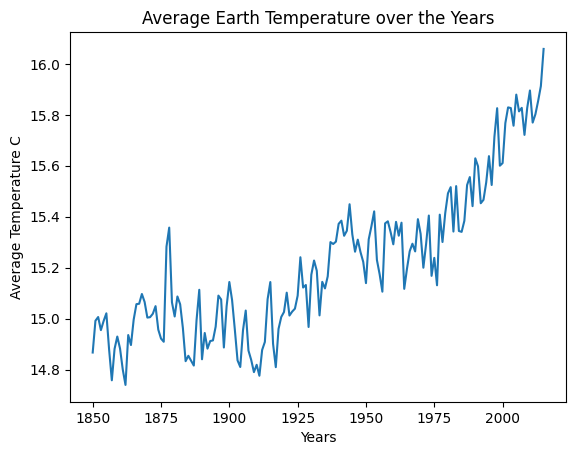

In [42]:
# Plot Average Earth Temperature over the years
g = sns.lineplot(data=df_temp_clean_graph, x='date', y='mean', markers=True)
g.set(xlabel = "Years", ylabel = "Average Temperature C", title = "Average Earth Temperature over the Years")
plt.show()

Based on the graph, we see that, overall, Earth temperature increases as time increases but within a small range (14.8 C to 16 C).

Finally, we are interested in seeing Earth's overall temperature against the continent temperatures.

In [43]:
# Combine earth and continent data
df1 = df_temp_clean.groupby([df_temp_clean['date'].dt.year])['LandAndOceanAverageTemperature'].agg(['mean', 'min', 'max']).reset_index()
df2 = df_temp_by_continent.groupby([df_temp_by_continent['date'].dt.year, 'continent'])['AverageTemperature'].agg(['mean', 'min', 'max']).reset_index()

df_for_temp_graph = df2.merge(df1, left_on = 'date', right_on = 'date', suffixes=('_continent', '_earth'))
df_for_temp_graph.head()

,date,continent,mean_continent,min_continent,max_continent,mean_earth,min_earth,max_earth
0,1850,Africa,22.095352,4.470,35.114,14.867167,12.833,16.783
1,1850,Americas,17.537286,-18.918,35.589,14.867167,12.833,16.783
2,1850,Asia,18.768808,-29.148,36.961,14.867167,12.833,16.783
3,1850,Europe,7.599627,-35.853,26.650,14.867167,12.833,16.783
4,1850,Oceania,14.382250,0.821,23.294,14.867167,12.833,16.783


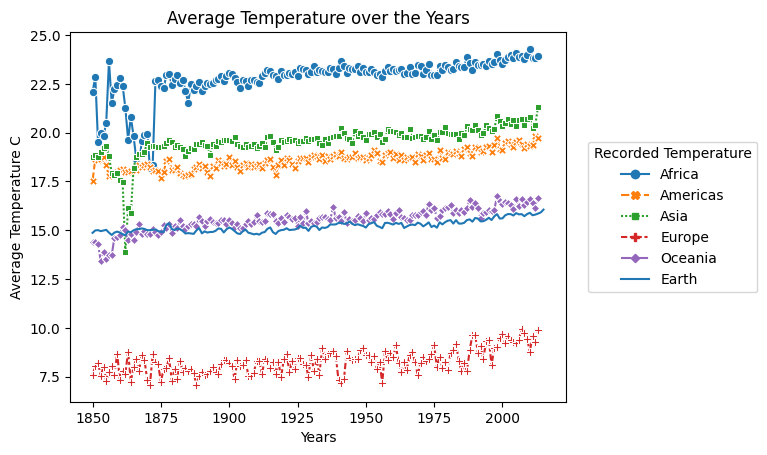

In [44]:
df_temp_clean_graph['group'] = "Earth"
g1 = sns.lineplot(data=df_for_temp_graph, x='date', y='mean_continent', hue='continent', style='continent', markers=True, errorbar=None)
g2 = sns.lineplot(data= df_temp_clean_graph, x = 'date', y = 'mean', hue = 'group', markers=True)
sns.move_legend(g1, "right", bbox_to_anchor=(1.4,0.5), title="Recorded Temperature")
g1.set(xlabel = "Years", ylabel = "Average Temperature C", title = "Average Temperature over the Years")
plt.show()

Based on the graph, the Earth's temperature is closer to the temperature of Oceania. As expected, it is in between the highest (Africa) and lowest (Europe) continent temperature. 

## 2.2 Disaster Tweets dataset
Let us looks at the climate related tweets and see what kind of events are associated with rising temteratures.

These tweets were collected during January 14, 2020, the hotest January on the record (according to [National Oceanic and Atmospheric Administration](https://www.noaa.gov/news/january-2020-was-earth-s-hottest-january-on-record))

Mount the next dataset Tweets.csv

In [45]:
!! kaggle datasets download -d vstepanenko/disaster-tweets

['Downloading disaster-tweets.zip to /content',
 '',
 '  0% 0.00/656k [00:00<?, ?B/s]',
 '',
 '100% 656k/656k [00:00<00:00, 129MB/s]']

In [46]:
# !! Please do it only once per runtime
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("drive/My Drive/CIS-545_Earth_Temperatures_Project")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
tweets_df = pd.read_csv('tweets.csv')
tweets_df.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [48]:
tweets_df.head(10)

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0
5,5,ablaze,OC,"If this child was Chinese, this tweet would ha...",0
6,6,ablaze,"London, England",Several houses have been set ablaze in Ngemsib...,1
7,7,ablaze,Bharat,Asansol: A BJP office in Salanpur village was ...,1
8,8,ablaze,"Accra, Ghana","National Security Minister, Kan Dapaah's side ...",0
9,9,ablaze,Searching,This creature who’s soul is no longer clarent ...,0


Let's find all the unique keywords in the `tweets_df` & convert them to a list. Also convert the Unique cities to a list. Export the Unique cities and Unique keywords to two different .csv  files through a DF step.  We then opened and read them manually, selecting the keywords relevant to weather and climate change, and placing them to related categories. 

In [49]:
# Explore the dataset
keywords_list = tweets_df.keyword.unique().tolist()
print("Unique keywords count: ",len(keywords_list))
tweet_cities = tweets_df.location.unique().tolist()
print("Unique cities in tweets:",len(tweet_cities))
# Keyword List to Df 
keywords_df = pd.DataFrame(keywords_list,columns = ['Tweet keywords'])
# First Tweet keywords File below 
keywords_df.to_csv("tweet_keywords.csv")
# The Tweets Cities Df Below , City names are Dirty 
tweet_cities_df = pd.DataFrame(tweet_cities,columns = ['Tweet cities'])
# TweetCities File to see the cities and assess cleanliness 
tweet_cities_df.to_csv("tweet_cities")

Unique keywords count:  219
Unique cities in tweets: 4505


Let us use the keywords to select relevant tweets.

In [50]:
tw_keywords_sel_df = pd.read_csv("tweet_keywords_select.csv")
tw_keywords_sel_df = tw_keywords_sel_df.loc[tw_keywords_sel_df['Selected'] == 'Y']
tw_keywords_sel_df.head()

,Unnamed: 0,Tweet keywords,Selected,Category
14,14,avalanche,Y,Extreme Precipitation
18,18,blaze,Y,Fires
23,23,blizzard,Y,Extreme Precipitation
38,38,bush%20fires,Y,Fires
55,55,cyclone,Y,Extreme Precipitation


In [51]:
# Select weather-related disaster tweets
climate_tweets_df = tw_keywords_sel_df.merge(tweets_df,left_on= 'Tweet keywords',right_on = 'keyword', how = 'inner')
climate_tweets_df = climate_tweets_df[climate_tweets_df['location'].notna()]
print("Tweets relevant to climate based disaster",len(climate_tweets_df))
climate_tweets_df

Tweets relevant to climate based disaster 1405


,Unnamed: 0,Tweet keywords,Selected,Category,id,keyword,location,text,target
0,14,avalanche,Y,Extreme Precipitation,665,avalanche,Hell,Washington has an avalanche rescue goat. His n...,0
1,14,avalanche,Y,Extreme Precipitation,666,avalanche,South Africa,petition for KFC to bring back the avalanche,0
3,14,avalanche,Y,Extreme Precipitation,668,avalanche,"Bangalore, India",1 BSF soldier killed in avalanche in Kashmir's...,1
5,14,avalanche,Y,Extreme Precipitation,670,avalanche,Vancouver,A skier caught in an avalanche in Banff Nation...,1
6,14,avalanche,Y,Extreme Precipitation,671,avalanche,"New York, USA",read everything Avalanche here! https://t.co/k...,0
...,...,...,...,...,...,...,...,...,...
1959,213,windstorm,Y,Extreme Wind,11135,windstorm,"Austin, Texas",I’m grateful to the Speaker for appointing me ...,0
1961,213,windstorm,Y,Extreme Wind,11137,windstorm,URUGUAY,There won't be much of a break across the sout...,1
1962,213,windstorm,Y,Extreme Wind,11138,windstorm,"State College, PA",There won't be much of a break across the sout...,1
1963,213,windstorm,Y,Extreme Wind,11139,windstorm,"Kelowna, B.C.",Our poor BBQ. Not only did the windstorm blow ...,1


In [52]:
# Only keep true disaster tweets, they are marked as target = 1 
climate_dis_tweets_df = climate_tweets_df[climate_tweets_df['target'] == 1]
climate_dis_tweets_df

,Unnamed: 0,Tweet keywords,Selected,Category,id,keyword,location,text,target
3,14,avalanche,Y,Extreme Precipitation,668,avalanche,"Bangalore, India",1 BSF soldier killed in avalanche in Kashmir's...,1
5,14,avalanche,Y,Extreme Precipitation,670,avalanche,Vancouver,A skier caught in an avalanche in Banff Nation...,1
7,14,avalanche,Y,Extreme Precipitation,672,avalanche,"Chennai, India",Five soldiers were trapped under the #avalanch...,1
8,14,avalanche,Y,Extreme Precipitation,673,avalanche,"Hyderabad, BHARAT",Three Army soldiers were killed and another wa...,1
9,14,avalanche,Y,Extreme Precipitation,674,avalanche,"Pune, India",JUST IN: Avalanche strikes Indian Army post in...,1
...,...,...,...,...,...,...,...,...,...
1957,213,windstorm,Y,Extreme Wind,11133,windstorm,California,Winter in NorCal is just Autumn Lite where it ...,1
1958,213,windstorm,Y,Extreme Wind,11134,windstorm,"Penzance, Cornwall",Windstorm: 'Level 2' for TUESDAY. Associated w...,1
1961,213,windstorm,Y,Extreme Wind,11137,windstorm,URUGUAY,There won't be much of a break across the sout...,1
1962,213,windstorm,Y,Extreme Wind,11138,windstorm,"State College, PA",There won't be much of a break across the sout...,1


In [53]:
# Group by category & prepares the data for plotting
categorized_df = climate_dis_tweets_df.groupby(['Category', 'Selected'])['location'].count().reset_index()
categorized_df.sort_values(by='location', inplace=True)
categorized_df

,Category,Selected,location
1,Extreme Heat,Y,5
4,Famine,Y,5
0,Drought,Y,8
5,Fires,Y,44
6,Flood,Y,44
7,Other,Y,47
3,Extreme Wind,Y,97
2,Extreme Precipitation,Y,104


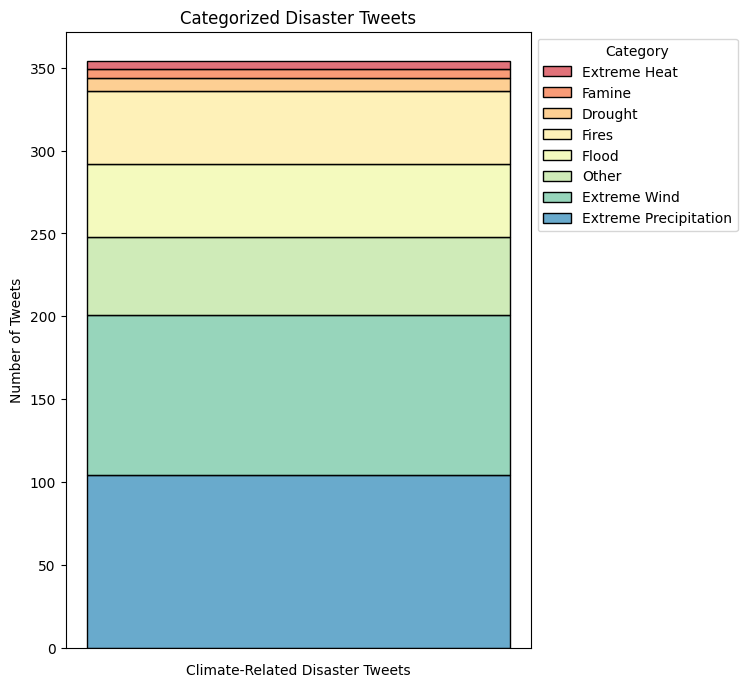

In [140]:
# Plot the Stacked bar chart in seaborn
fig, ax = plt.subplots(figsize = (6,8))
ax = sns.histplot(categorized_df, x='Selected', hue='Category', weights='location', multiple='stack', palette='Spectral')
ax.set(title = 'Categorized Disaster Tweets', xticklabels='', xlabel = 'Climate-Related Disaster Tweets')
ax.tick_params(bottom = False)
ax.set_ylabel('Number of Tweets')

# Move the legend to the side
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 1))

Before we move on, let's explore some text-based analysis and look at disaster tweets' text. 

We found it valuable and interesting to visualize the text of the tweets via Word Cloud.

In [56]:
# Install necessary libraties
import nltk
nltk.__version__
nltk.download('punkt')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [57]:
# Download stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
stopwords.add('https')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [58]:
# This function tokenizes the tweet text strings and returns the list of tokens 
# all alphabetic, lowercase, and contain no stopwords
def tokenize_content(content):
  list_of_tokens = nltk.word_tokenize(content)
  tokens = []
  for token in list_of_tokens:
    if token.isalpha() and token.lower() not in stopwords:
      token = token.lower()
      tokens.append(token)
  return tokens

In [59]:
# Creates the list of tweet texts & prepares it for tokenization
tweet_texts = list(climate_dis_tweets_df['text'])

In [60]:
# Tokenizes text and places them into tokens
tokens = []
for line in tweet_texts:
  tokens_list = tokenize_content(line)
  for t in tokens_list:
    if t != 'https':
      tokens.append(t)

print(len(tokens))

3423


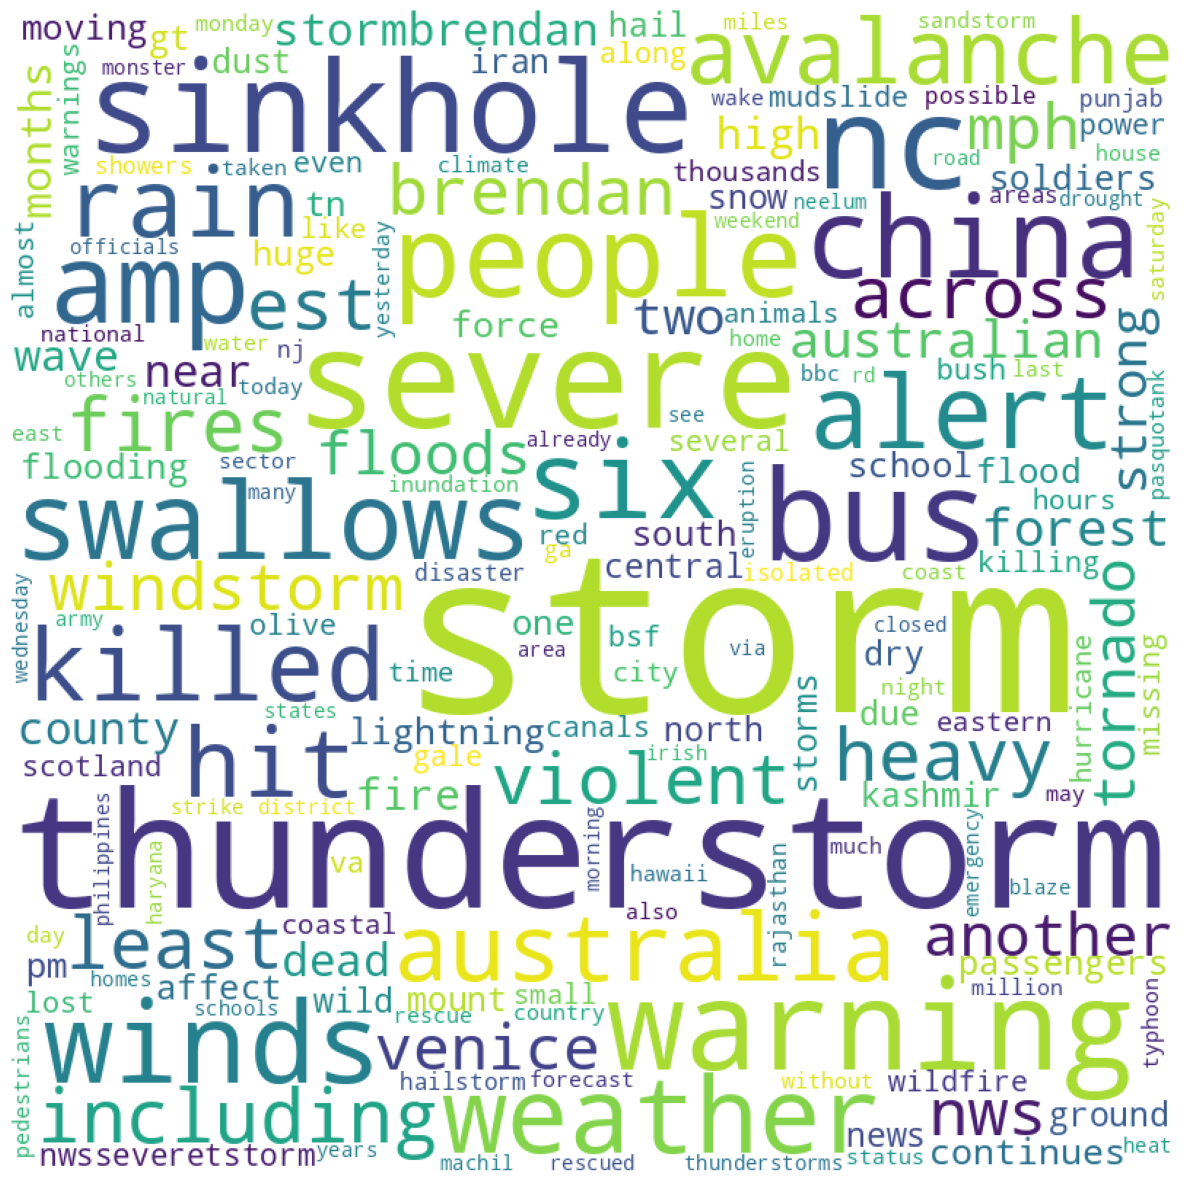

In [61]:
# Makes a word cloud for disaster tweet texts
token_string = ''
token_string += ' '.join(tokens)+' '

top_freq = Counter(tokens).most_common()
top_freq = dict(top_freq)

wordcloud = WordCloud(width=800, height=800, background_color ='white', min_font_size = 12).fit_words(top_freq)
plt.figure(figsize = (12, 12), facecolor = None)
plt.imshow(wordcloud)
plt.tight_layout(pad = 0)
plt.axis("off")
plt.show()

## 2.3 OECD dataset part 1


OECD Dataset on climate and Economic data.

OECD FUA city dataset link
https://stats.oecd.org/Index.aspx?datasetcode=FUA_CITY
https://stats.oecd.org/Index.aspx?DataSetCode=CITIES#

It has GDP per capita data. This enables us to see the income level of the cities which are most impacted by climate change.

In [62]:
oecd_cities_climate = pd.read_csv("FUA_CITY_OECD_DATA.csv")
oecd_cities_climate.dtypes

LOCATION            object
Country             object
TL                  object
Territory level     object
GEO                 object
Geography           object
VAR                 object
Variable            object
TIME                 int64
Time                 int64
Value              float64
Flag Codes         float64
Flags              float64
dtype: object

In [63]:
oecd_cities_climate.head()
variables_tracked = oecd_cities_climate.Variable.unique()
print("variables tracked:",len(variables_tracked))
print(variables_tracked)

variables tracked: 25
['Heating degree days (Sum over a year of the differences between the threshold temperature (15.5°C) and the daily mean outdoor temperature when the daily mean outdoor temperature is below 15.5°C)'
 'Days of very strong heat stress (UTCI > 38°C)'
 'Cooling degree days (Sum over a year of the differences between the daily mean outdoor air temperature and the threshold temperature (22°C) when the daily mean outdoor temperature is above 22°C)'
 'Days of extreme heat stress (UTCI > 46°C)'
 'Days of strong heat stress (UTCI > 32°C)'
 'Additional days of very strong heat stress (UTCI > 38°C) compared to the 1981-2010 average'
 'Nightime urban heat island: difference in land surface temperature (in °C) between the built-up area and its surroundings'
 'Share of population esposed to river flooding, 50-year return period'
 'Share of population exposed to river flooding, 10-year return period'
 'Area burned as a share of total area'
 'Share of population exposed to coastal 

There are 25 climate variables tracked by city. We can flatten the data set and make the variables columns and put the dats in the row form for ease of use if we wish to look at all 25. Need to decide how to analyze. Below we check the number of cities and compare to the temperature dataset

In [64]:
oecd_cities = oecd_cities_climate.loc[oecd_cities_climate['TL']=='CITY']
oecd_cities_list = oecd_cities.Geography.unique().tolist()
print("oecd cities count",len(oecd_cities_list))

oecd cities count 1385


OECD city gdp data is from link below https://stats.oecd.org/Index.aspx?datasetcode=FUA_CITY

GDP data exists here at country level but the city is called "Functional Urban Area"(FUA), The field VAR = GDP_REAL_PPP indicates per capita GDP in the city by year from 2001 and we can use this to rate the city amongst the cities. We can keep the data only for the year 2015 as GDP is normalized to prices in the year 2015. To be decided by the group

In [65]:
oecd_cities_gdp = pd.read_csv("FUA_CITY_GDP.csv")
oecd_cities_gdp.head()
oecd_gdp_cities_list = oecd_cities_gdp.Geography.unique()
print("count of cities for gdp",len(oecd_gdp_cities_list))

count of cities for gdp 699


Keep only per capita GDP rows for the year 2015 . Put the cities into 4 quartiles where 1 is high gdp and 4 is lowest gdp

In [66]:
oecd_quartile_list = oecd_cities_gdp.Value.quantile([0.25,0.50,0.75]).tolist()
print(oecd_quartile_list)

[8722.75, 39698.5, 100516.5]


In [67]:
# hard coded values from above cell
def quartile_calc(x):

  if x < 11519.0:
    return 4
  else:
    if x < 19741.0:
      return 3
    else:
      if x< 38664.5:
        return 2
      else:
        return 1

oecd_cities_gdp = oecd_cities_gdp.loc[oecd_cities_gdp['VAR']== "GDP_REAL_PPP" ]
oecd_cities_gdp = oecd_cities_gdp.loc[oecd_cities_gdp['TIME'] == 2015]
#oecd_cities_gdp.head()


oecd_cities_gdp = oecd_cities_gdp.assign(Quartile = lambda x : x.Value.apply(quartile_calc) )
#oecd_cities_gdp.head()

The oecd cities all have a GEO field and we will use this to merge in gdp quartile data where applicable. The GDP is at the Functional Urban Area level whereas the climate data is both at the FUA level and the city level. For the purposes of impact of extreme weather on lower income neighborhoods, it is probably better to use the FUA level analysis. 


In [68]:
oecd_cities_climate_gdp = oecd_cities_climate.merge(oecd_cities_gdp[['GEO','Quartile']],left_on = 'GEO', right_on ='GEO',how = 'left' )
oecd_full_cities_list = oecd_cities_climate_gdp.Geography.unique().tolist()
oecd_cities_climate_gdp.tail()

,LOCATION,Country,TL,Territory level,GEO,Geography,VAR,Variable,TIME,Time,Value,Flag Codes,Flags,Quartile
650546,USA,United States,CITY,City,USA68C,Kent,FIRES_POP_SH,Share of population exposed to at least one fo...,2017,2017,0.0,NaN,NaN,NaN
650547,USA,United States,CITY,City,USA68C,Kent,FIRES_POP_SH,Share of population exposed to at least one fo...,2018,2018,0.0,NaN,NaN,NaN
650548,USA,United States,CITY,City,USA68C,Kent,FIRES_POP_SH,Share of population exposed to at least one fo...,2019,2019,0.0,NaN,NaN,NaN
650549,USA,United States,CITY,City,USA68C,Kent,FIRES_POP_SH,Share of population exposed to at least one fo...,2020,2020,0.0,NaN,NaN,NaN
650550,USA,United States,CITY,City,USA68C,Kent,FIRES_POP_SH,Share of population exposed to at least one fo...,2021,2021,0.0,NaN,NaN,NaN


Look for the matches in city names between the temperature data set and OECD data set. There appear to be 528 ( see code cell output below)
Conclusions:
 temperature dataset can drop cities with too much missing data. 
 temperature dataset can possibly interpolate values for missing data for cities that are retained.
 the temperature data set can be used to days of heat stress.
 We can match the cities in the 2 data sets for deeper analysis

In [69]:
cities_temp_and_oecd = []
# cities_from_temp_list has the cities from df_city_temp, oecd_full_cities_list has cities from oecd datasets after merge
# code below finds the common cities
for x in cities_from_temp_list:
  if x in oecd_full_cities_list:
    cities_temp_and_oecd.append(x)
print(len(cities_temp_and_oecd))

528


## 2.4 OECD dataset part 2

We are interested in the relationship between economy and temperature. We can look into this by analyzing the Organisation for Economic Co-operation and Development (OECD) dataset.

https://stats.oecd.org/Index.aspx?datasetcode=FUA_CITY

In [70]:
cd /content/

/content


In [71]:
# Download dataset
!!kaggle datasets download --force -d glaizatan/oecd-dataset

['Downloading oecd-dataset.zip to /content',
 '',
 '  0% 0.00/7.62M [00:00<?, ?B/s]',
 ' 66% 5.00M/7.62M [00:00<00:00, 47.7MB/s]',
 '',
 '100% 7.62M/7.62M [00:00<00:00, 66.0MB/s]']

In [72]:
# Unzip folder in Colab content folder
!unzip /content/oecd-dataset.zip

Archive:  /content/oecd-dataset.zip
  inflating: FUA_CITY_Air_pollution.csv  
  inflating: FUA_CITY_Climate_hazards.csv  
  inflating: FUA_CITY_Demography.csv  
  inflating: FUA_CITY_Economy.csv    
  inflating: FUA_CITY_Territorial_Organization.csv  


In [73]:
# TODO: Either remove this or next one

# Download datasets
df_city_demography = pd.read_csv("FUA_CITY_Demography.csv")
df_economy = pd.read_csv("FUA_CITY_Economy.csv")
df_air_pollution = pd.read_csv("FUA_CITY_Air_pollution.csv")
df_climate_hazards = pd.read_csv("FUA_CITY_Climate_hazards.csv")
df_territorial_organization = pd.read_csv("FUA_CITY_Territorial_Organization.csv")

In [74]:
# If above does not work, uncomment below to get dataset
# df_city_demography = pd.read_csv("/content/drive/MyDrive/CIS-545_Earth_Temperatures_Project/Colab/FUA_CITY_Demography.csv")
# df_economy = pd.read_csv("/content/drive/MyDrive/CIS-545_Earth_Temperatures_Project/Colab/FUA_CITY_Economy.csv")
# df_air_pollution = pd.read_csv("/content/drive/MyDrive/CIS-545_Earth_Temperatures_Project/Colab/FUA_CITY_Air_pollution.csv")
# df_climate_hazards = pd.read_csv("/content/drive/MyDrive/CIS-545_Earth_Temperatures_Project/Colab/FUA_CITY_Climate_hazards.csv")
# df_territorial_organization = pd.read_csv("/content/drive/MyDrive/CIS-545_Earth_Temperatures_Project/Colab/FUA_CITY_Territorial_Organization.csv")


### Demography

In [75]:
df_city_demography.head()

,LOCATION,Country,TL,Territory level,GEO,Geography,VAR,Variable,TIME,Time,Value,Flag Codes,Flags
0,AUS,Australia,COUNTRY,Country,AUS,Australia,T_T,"Population, all ages, administrative data",2001,2001,19272100.0,NaN,NaN
1,AUS,Australia,COUNTRY,Country,AUS,Australia,T_T,"Population, all ages, administrative data",2002,2002,19492800.0,NaN,NaN
2,AUS,Australia,COUNTRY,Country,AUS,Australia,T_T,"Population, all ages, administrative data",2003,2003,19718400.0,NaN,NaN
3,AUS,Australia,COUNTRY,Country,AUS,Australia,T_T,"Population, all ages, administrative data",2004,2004,19930400.0,NaN,NaN
4,AUS,Australia,COUNTRY,Country,AUS,Australia,T_T,"Population, all ages, administrative data",2005,2005,20174500.0,NaN,NaN


In [76]:
# Check for nulls and duplicates
df_city_demography.info() # no nulls
len(df_city_demography) - len(df_city_demography.drop_duplicates()) # no duplicates

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243223 entries, 0 to 243222
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   LOCATION         243223 non-null  object 
 1   Country          243223 non-null  object 
 2   TL               243223 non-null  object 
 3   Territory level  243223 non-null  object 
 4   GEO              243223 non-null  object 
 5   Geography        243223 non-null  object 
 6   VAR              243223 non-null  object 
 7   Variable         243223 non-null  object 
 8   TIME             243223 non-null  int64  
 9   Time             243223 non-null  int64  
 10  Value            243223 non-null  float64
 11  Flag Codes       0 non-null       float64
 12  Flags            0 non-null       float64
dtypes: float64(3), int64(2), object(8)
memory usage: 24.1+ MB


0

In [77]:
# Look at the unique values in each column and determine which features are needed
for x in df_city_demography.columns:
  print(x, df_city_demography[x].unique()) 

LOCATION ['AUS' 'AUT' 'BEL' 'BGR' 'CAN' 'HUN' 'IRL' 'ISL' 'ITA' 'USA' 'CHE' 'CHL'
 'COL' 'JPN' 'CZE' 'DEU' 'KOR' 'LTU' 'LUX' 'LVA' 'MEX' 'DNK' 'ESP' 'MLT'
 'NLD' 'NOR' 'NZL' 'POL' 'EST' 'FIN' 'FRA' 'PRT' 'GBR' 'ROU' 'SVK' 'SVN'
 'SWE' 'TUR' 'GRC' 'HRV']
Country ['Australia' 'Austria' 'Belgium' 'Bulgaria' 'Canada' 'Hungary' 'Ireland'
 'Iceland' 'Italy' 'United States' 'Switzerland' 'Chile' 'Colombia'
 'Japan' 'Czech Republic' 'Germany' 'Korea' 'Lithuania' 'Luxembourg'
 'Latvia' 'Mexico' 'Denmark' 'Spain' 'Malta' 'Netherlands' 'Norway'
 'New Zealand' 'Poland' 'Estonia' 'Finland' 'France' 'Portugal'
 'United Kingdom' 'Romania' 'Slovak Republic' 'Slovenia' 'Sweden'
 'Türkiye' 'Greece' 'Croatia']
TL ['COUNTRY' 'FUA' 'CITY']
Territory level ['Country' 'Functional Urban Area' 'City']
GEO ['AUS' 'AUS01F' 'AUS01C' ... 'USA149F' 'USA149C' 'USA14F']
Geography ['Australia' 'Greater Sydney' 'Gosford - Springfield' 'Greater Melbourne'
 'Greater Brisbane' 'Greater Perth' 'Rockingham' 'Greater Adelaid

In [78]:
# We are only interested in the following to connect to the temperature dataset
# - Variable == 'Population, all ages, administrative data'
# - TL == 'COUNTRY'
df_city_demography_clean = df_city_demography[(df_city_demography['Variable'] == 'Population, all ages, administrative data') & (df_city_demography['TL'] == 'COUNTRY')]

# We check the columns again for unique values
for x in df_city_demography_clean.columns:
  if x != 'Value':
    print(x, df_city_demography_clean[x].unique()) 

# Looking at the remaining columns, we can drop the following due to duplicates and redundancy: TL, Territory Level, GEO, Geography, VAR, Variable, TIME, Flag Codes, Flags
# We also rename Value to Population
df_city_demography_country_clean = df_city_demography_clean.drop(columns = ['TL', 'Territory level', 'GEO', 'Geography', 'VAR', 'Variable', 'TIME', 'Flag Codes', 'Flags']).rename(columns = {'Value': 'Population'})
df_city_demography_country_clean.head()


LOCATION ['AUS' 'AUT' 'BEL' 'BGR' 'CAN' 'HUN' 'IRL' 'ISL' 'ITA' 'CHE' 'CHL' 'COL'
 'JPN' 'CZE' 'DEU' 'KOR' 'LTU' 'LUX' 'LVA' 'MEX' 'DNK' 'ESP' 'MLT' 'NLD'
 'NOR' 'NZL' 'POL' 'EST' 'FIN' 'FRA' 'PRT' 'GBR' 'ROU' 'SVK' 'SVN' 'SWE'
 'TUR' 'GRC' 'HRV' 'USA']
Country ['Australia' 'Austria' 'Belgium' 'Bulgaria' 'Canada' 'Hungary' 'Ireland'
 'Iceland' 'Italy' 'Switzerland' 'Chile' 'Colombia' 'Japan'
 'Czech Republic' 'Germany' 'Korea' 'Lithuania' 'Luxembourg' 'Latvia'
 'Mexico' 'Denmark' 'Spain' 'Malta' 'Netherlands' 'Norway' 'New Zealand'
 'Poland' 'Estonia' 'Finland' 'France' 'Portugal' 'United Kingdom'
 'Romania' 'Slovak Republic' 'Slovenia' 'Sweden' 'Türkiye' 'Greece'
 'Croatia' 'United States']
TL ['COUNTRY']
Territory level ['Country']
GEO ['AUS' 'AUT' 'BEL' 'BGR' 'CAN' 'HUN' 'IRL' 'ISL' 'ITA' 'CHE' 'CHL' 'COL'
 'JPN' 'CZE' 'DEU' 'KOR' 'LTU' 'LUX' 'LVA' 'MEX' 'DNK' 'ESP' 'MLT' 'NLD'
 'NOR' 'NZL' 'POL' 'EST' 'FIN' 'FRA' 'PRT' 'GBR' 'ROU' 'SVK' 'SVN' 'SWE'
 'TUR' 'GRC' 'HRV' 'USA']
Geograp

,LOCATION,Country,Time,Population
0,AUS,Australia,2001,19272100.0
1,AUS,Australia,2002,19492800.0
2,AUS,Australia,2003,19718400.0
3,AUS,Australia,2004,19930400.0
4,AUS,Australia,2005,20174500.0


### Economy

In [79]:
df_economy.head()

,LOCATION,Country,TL,Territory level,GEO,Geography,VAR,Variable,TIME,Time,Value,Flag Codes,Flags
0,ESP,Spain,FUA,Functional Urban Area,ES002F,Barcelona,GDP_PW_REAL_PPP,"Labour productivity (GDP per worker in USD, co...",2001,2001,80384.0,NaN,NaN
1,ESP,Spain,FUA,Functional Urban Area,ES002F,Barcelona,GDP_PW_REAL_PPP,"Labour productivity (GDP per worker in USD, co...",2002,2002,82528.0,NaN,NaN
2,ESP,Spain,FUA,Functional Urban Area,ES002F,Barcelona,GDP_PW_REAL_PPP,"Labour productivity (GDP per worker in USD, co...",2003,2003,82882.0,NaN,NaN
3,ESP,Spain,FUA,Functional Urban Area,ES002F,Barcelona,GDP_PW_REAL_PPP,"Labour productivity (GDP per worker in USD, co...",2004,2004,82727.0,NaN,NaN
4,ESP,Spain,FUA,Functional Urban Area,ES002F,Barcelona,GDP_PW_REAL_PPP,"Labour productivity (GDP per worker in USD, co...",2005,2005,82931.0,NaN,NaN


In [80]:
df_economy.info() # no nulls
len(df_economy) - len(df_economy.drop_duplicates()) # no duplicates

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62688 entries, 0 to 62687
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   LOCATION         62688 non-null  object 
 1   Country          62688 non-null  object 
 2   TL               62688 non-null  object 
 3   Territory level  62688 non-null  object 
 4   GEO              62688 non-null  object 
 5   Geography        62688 non-null  object 
 6   VAR              62688 non-null  object 
 7   Variable         62688 non-null  object 
 8   TIME             62688 non-null  int64  
 9   Time             62688 non-null  int64  
 10  Value            62688 non-null  float64
 11  Flag Codes       3278 non-null   object 
 12  Flags            3278 non-null   object 
dtypes: float64(1), int64(2), object(10)
memory usage: 6.2+ MB


0

In [81]:
# Look at the unique values in each column and determine which features are needed
for x in df_economy.columns:
  print(x, df_economy[x].unique())

LOCATION ['ESP' 'GBR' 'HUN' 'MEX' 'SWE' 'JPN' 'CZE' 'NOR' 'POL' 'USA' 'KOR' 'FRA'
 'EST' 'TUR' 'DEU' 'AUS' 'CHE' 'BGR' 'NLD' 'ROU' 'CAN' 'COL' 'CHL' 'ITA'
 'NZL' 'FIN' 'LTU' 'GRC' 'AUT' 'HRV' 'BEL' 'IRL' 'LUX' 'DNK' 'SVK' 'LVA'
 'SVN' 'PRT' 'MLT']
Country ['Spain' 'United Kingdom' 'Hungary' 'Mexico' 'Sweden' 'Japan'
 'Czech Republic' 'Norway' 'Poland' 'United States' 'Korea' 'France'
 'Estonia' 'Türkiye' 'Germany' 'Australia' 'Switzerland' 'Bulgaria'
 'Netherlands' 'Romania' 'Canada' 'Colombia' 'Chile' 'Italy' 'New Zealand'
 'Finland' 'Lithuania' 'Greece' 'Austria' 'Croatia' 'Belgium' 'Ireland'
 'Luxembourg' 'Denmark' 'Slovak Republic' 'Latvia' 'Slovenia' 'Portugal'
 'Malta']
TL ['FUA']
Territory level ['Functional Urban Area']
GEO ['ES002F' 'UK026F' 'HU005F' 'MEX15F' 'SE006F' 'JPN09F' 'CZ001F' 'SE001F'
 'NO002F' 'PL014F' 'USA162F' 'MEX32F' 'KOR06F' 'UK550F' 'USA08F' 'FR011F'
 'EE001F' 'TR022F' 'UK557F' 'UK027F' 'JPN42F' 'USA34F' 'USA143F' 'MEX44F'
 'DE081F' 'USA95F' 'TR002F' 'UK019F' 

In [82]:
# We are only interested in the following to connect to the temperature dataset
# - Variable == 'GDP (Million USD, constant prices, constant PPP, base year 2015)'
df_economy_clean = df_economy[(df_economy['Variable'] == 'GDP (Million USD, constant prices, constant PPP, base year 2015)')]

# We check the columns again for unique values. 
for x in df_economy_clean.columns:
  if x != 'Value':
    print(x, df_economy_clean[x].unique()) 

# Since the territory level is Functional Urban Area, we group by country and get the average GDP value.
df_economy_country_clean = df_economy_clean.groupby(['Time', 'LOCATION', 'Country'])['Value'].agg(['mean']).reset_index().rename(columns = {'mean': 'GDP'})
df_economy_country_clean.head()


LOCATION ['GBR' 'HUN' 'NOR' 'SWE' 'POL' 'USA' 'FRA' 'JPN' 'DEU' 'MEX' 'ESP' 'CHE'
 'BGR' 'KOR' 'CHL' 'NLD' 'ITA' 'COL' 'GRC' 'AUT' 'TUR' 'BEL' 'ROU' 'LUX'
 'CZE' 'IRL' 'CAN' 'HRV' 'NZL' 'AUS' 'DNK' 'PRT' 'FIN' 'LVA' 'LTU' 'SVK'
 'EST' 'MLT' 'SVN']
Country ['United Kingdom' 'Hungary' 'Norway' 'Sweden' 'Poland' 'United States'
 'France' 'Japan' 'Germany' 'Mexico' 'Spain' 'Switzerland' 'Bulgaria'
 'Korea' 'Chile' 'Netherlands' 'Italy' 'Colombia' 'Greece' 'Austria'
 'Türkiye' 'Belgium' 'Romania' 'Luxembourg' 'Czech Republic' 'Ireland'
 'Canada' 'Croatia' 'New Zealand' 'Australia' 'Denmark' 'Portugal'
 'Finland' 'Latvia' 'Lithuania' 'Slovak Republic' 'Estonia' 'Malta'
 'Slovenia']
TL ['FUA']
Territory level ['Functional Urban Area']
GEO ['UK026F' 'HU005F' 'NO002F' 'SE001F' 'PL014F' 'USA162F' 'FR011F' 'JPN42F'
 'USA143F' 'DE081F' 'USA08F' 'MEX17F' 'ES069F' 'USA46F' 'CH001F' 'DE036F'
 'BG002F' 'USA133F' 'HU001F' 'DE100F' 'KOR15F' 'FR040F' 'DE026F' 'USA101F'
 'USA111F' 'CH003F' 'DE087F' 'CL020

,Time,LOCATION,Country,GDP
0,2001,AUS,Australia,53725.000000
1,2001,AUT,Austria,37949.333333
2,2001,BEL,Belgium,35158.750000
3,2001,BGR,Bulgaria,9255.250000
4,2001,CAN,Canada,51039.375000


### Air pollution

In [83]:
df_air_pollution.head()

,LOCATION,Country,TL,Territory level,GEO,Geography,VAR,Variable,TIME,Time,Value,Flag Codes,Flags
0,USA,United States,FUA,Functional Urban Area,USA180F,Punta Gorda,SPEX_MORE_THAN_15,Share of population exposed to a level of PM2....,2000,2000,0.0,NaN,NaN
1,USA,United States,FUA,Functional Urban Area,USA180F,Punta Gorda,SPEX_MORE_THAN_15,Share of population exposed to a level of PM2....,2001,2001,0.0,NaN,NaN
2,USA,United States,FUA,Functional Urban Area,USA180F,Punta Gorda,SPEX_MORE_THAN_15,Share of population exposed to a level of PM2....,2002,2002,0.0,NaN,NaN
3,USA,United States,FUA,Functional Urban Area,USA180F,Punta Gorda,SPEX_MORE_THAN_15,Share of population exposed to a level of PM2....,2003,2003,0.0,NaN,NaN
4,USA,United States,FUA,Functional Urban Area,USA180F,Punta Gorda,SPEX_MORE_THAN_15,Share of population exposed to a level of PM2....,2004,2004,0.0,NaN,NaN


In [84]:
df_air_pollution.info() # no nulls
len(df_air_pollution) - len(df_air_pollution.drop_duplicates()) # no duplicates

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334530 entries, 0 to 334529
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   LOCATION         334530 non-null  object 
 1   Country          334530 non-null  object 
 2   TL               334530 non-null  object 
 3   Territory level  334530 non-null  object 
 4   GEO              334530 non-null  object 
 5   Geography        334530 non-null  object 
 6   VAR              334530 non-null  object 
 7   Variable         334530 non-null  object 
 8   TIME             334530 non-null  int64  
 9   Time             334530 non-null  int64  
 10  Value            334530 non-null  float64
 11  Flag Codes       0 non-null       float64
 12  Flags            0 non-null       float64
dtypes: float64(3), int64(2), object(8)
memory usage: 33.2+ MB


0

In [85]:
# no duplicates
len(df_city_demography_clean) - len(df_city_demography_clean.drop_duplicates())

0

In [86]:
# Look at the unique values in each column and determine which features are needed
for x in df_air_pollution.columns:
  print(x, df_air_pollution[x].unique())

LOCATION ['USA' 'GBR' 'MEX' 'AUS' 'FRA' 'ROU' 'ITA' 'POL' 'BGR' 'JPN' 'DEU' 'TUR'
 'HRV' 'SWE' 'NLD' 'CAN' 'COL' 'FIN' 'KOR' 'GRC' 'LTU' 'CHL' 'ESP' 'NZL'
 'HUN' 'BEL' 'DNK' 'CZE' 'PRT' 'CHE' 'AUT' 'IRL' 'EST' 'NOR' 'LVA' 'SVK'
 'SVN' 'LUX' 'MLT' 'ISL']
Country ['United States' 'United Kingdom' 'Mexico' 'Australia' 'France' 'Romania'
 'Italy' 'Poland' 'Bulgaria' 'Japan' 'Germany' 'Türkiye' 'Croatia'
 'Sweden' 'Netherlands' 'Canada' 'Colombia' 'Finland' 'Korea' 'Greece'
 'Lithuania' 'Chile' 'Spain' 'New Zealand' 'Hungary' 'Belgium' 'Denmark'
 'Czech Republic' 'Portugal' 'Switzerland' 'Austria' 'Ireland' 'Estonia'
 'Norway' 'Latvia' 'Slovak Republic' 'Slovenia' 'Luxembourg' 'Malta'
 'Iceland']
TL ['FUA' 'CITY']
Territory level ['Functional Urban Area' 'City']
GEO ['USA180F' 'USA15F' 'UK562C' ... 'DE030C' 'JPN09C' 'UK045C']
Geography ['Punta Gorda' 'Minneapolis' 'Preston' ... 'Hamm' 'Rockingham'
 'Vila Franca de Xira']
VAR ['SPEX_MORE_THAN_15' 'SPEX_MORE_THAN_5' 'SPEX_MORE_THAN_10' 'PWM_E

In [87]:
# We are only interested in the following to connect to the temperature dataset
# - Variable ==  'Mean population exposure to PM2.5 air pollution'
# - TL == 'FUA'
df_air_pollution_clean = df_air_pollution[(df_air_pollution['Variable'] == 'Mean population exposure to PM2.5 air pollution') & (df_air_pollution['TL'] == 'FUA')]

# We check the columns again for unique values. 
for x in df_air_pollution_clean.columns:
  if x != 'Value':
    print(x, df_air_pollution_clean[x].unique()) 

# Since the territory level is Functional Urban Area and City, to be consistent, we filter by FUA, group by country and get the average air pollution.
df_air_pollution_clean = df_air_pollution_clean.groupby(['Time', 'LOCATION', 'Country'])['Value'].agg(['mean']).reset_index().rename(columns = {'mean': 'Air Pollution'})
df_air_pollution_clean.head()

LOCATION ['FRA' 'GBR' 'JPN' 'MEX' 'USA' 'CAN' 'GRC' 'TUR' 'ESP' 'POL' 'DEU' 'LTU'
 'COL' 'CHE' 'CHL' 'AUT' 'ITA' 'NZL' 'CZE' 'ROU' 'DNK' 'SVK' 'BGR' 'HRV'
 'AUS' 'BEL' 'PRT' 'NLD' 'EST' 'SWE' 'HUN' 'KOR' 'LVA' 'IRL' 'ISL' 'NOR'
 'SVN' 'FIN' 'LUX' 'MLT']
Country ['France' 'United Kingdom' 'Japan' 'Mexico' 'United States' 'Canada'
 'Greece' 'Türkiye' 'Spain' 'Poland' 'Germany' 'Lithuania' 'Colombia'
 'Switzerland' 'Chile' 'Austria' 'Italy' 'New Zealand' 'Czech Republic'
 'Romania' 'Denmark' 'Slovak Republic' 'Bulgaria' 'Croatia' 'Australia'
 'Belgium' 'Portugal' 'Netherlands' 'Estonia' 'Sweden' 'Hungary' 'Korea'
 'Latvia' 'Ireland' 'Iceland' 'Norway' 'Slovenia' 'Finland' 'Luxembourg'
 'Malta']
TL ['FUA']
Territory level ['Functional Urban Area']
GEO ['FR014F' 'UK557F' 'JPN18F' ... 'DE040F' 'USA99F' 'TR008F']
Geography ['Cannes-Antibes' 'Blackburn with Darwen' 'Oita' ... 'Rostock' 'Mahoning'
 'Edirne']
VAR ['PWM_EX']
Variable ['Mean population exposure to PM2.5 air pollution']
TIME [2000 

,Time,LOCATION,Country,Air Pollution
0,2000,AUS,Australia,7.266667
1,2000,AUT,Austria,20.033333
2,2000,BEL,Belgium,19.378571
3,2000,BGR,Bulgaria,25.288235
4,2000,CAN,Canada,10.196154


### Territory

In [88]:
df_territorial_organization.head()

,LOCATION,Country,TL,Territory level,GEO,Geography,VAR,Variable,TIME,Time,Value,Flag Codes,Flags
0,DEU,Germany,CITY,City,DE034C,Mönchengladbach,URB_AREA,Urbanised area (built-up area or land for urba...,2014,2014,53.0,NaN,NaN
1,GRC,Greece,FUA,Functional Urban Area,EL006F,Volos,URB_AREA_PC,Urbanised area per capita (m² per capita),2014,2014,257.0,NaN,NaN
2,USA,United States,FUA,Functional Urban Area,USA112F,Cameron,URB_AREA_PC,Urbanised area per capita (m² per capita),2014,2014,233.0,NaN,NaN
3,POL,Poland,CITY,City,PL056C,Zabrze,URB_AREA,Urbanised area (built-up area or land for urba...,2014,2014,32.0,NaN,NaN
4,POL,Poland,FUA,Functional Urban Area,PL008F,Bydgoszcz,URB_AREA,Urbanised area (built-up area or land for urba...,2014,2014,82.0,NaN,NaN


In [89]:
df_territorial_organization.info() # no nulls
len(df_territorial_organization) - len(df_territorial_organization.drop_duplicates()) # no duplicates

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84436 entries, 0 to 84435
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   LOCATION         84436 non-null  object 
 1   Country          84436 non-null  object 
 2   TL               84436 non-null  object 
 3   Territory level  84436 non-null  object 
 4   GEO              84436 non-null  object 
 5   Geography        84436 non-null  object 
 6   VAR              84436 non-null  object 
 7   Variable         84436 non-null  object 
 8   TIME             84436 non-null  int64  
 9   Time             84436 non-null  int64  
 10  Value            84436 non-null  float64
 11  Flag Codes       0 non-null      float64
 12  Flags            0 non-null      float64
dtypes: float64(3), int64(2), object(8)
memory usage: 8.4+ MB


0

In [90]:
# Look at the unique values in each column and determine which features are needed
for x in df_territorial_organization.columns:
  print(x, df_territorial_organization[x].unique())

LOCATION ['DEU' 'GRC' 'USA' 'POL' 'DNK' 'IRL' 'MEX' 'FRA' 'SWE' 'ESP' 'NZL' 'TUR'
 'NOR' 'JPN' 'CAN' 'CHL' 'ITA' 'LVA' 'SVK' 'ROU' 'COL' 'GBR' 'HRV' 'KOR'
 'HUN' 'NLD' 'BGR' 'BEL' 'FIN' 'AUT' 'CZE' 'PRT' 'AUS' 'CHE' 'ISL' 'LTU'
 'EST' 'SVN' 'LUX' 'MLT']
Country ['Germany' 'Greece' 'United States' 'Poland' 'Denmark' 'Ireland' 'Mexico'
 'France' 'Sweden' 'Spain' 'New Zealand' 'Türkiye' 'Norway' 'Japan'
 'Canada' 'Chile' 'Italy' 'Latvia' 'Slovak Republic' 'Romania' 'Colombia'
 'United Kingdom' 'Croatia' 'Korea' 'Hungary' 'Netherlands' 'Bulgaria'
 'Belgium' 'Finland' 'Austria' 'Czech Republic' 'Portugal' 'Australia'
 'Switzerland' 'Iceland' 'Lithuania' 'Estonia' 'Slovenia' 'Luxembourg'
 'Malta']
TL ['CITY' 'FUA']
Territory level ['City' 'Functional Urban Area']
GEO ['DE034C' 'EL006F' 'USA112F' ... 'DE017C' 'DE063C' 'UK553C']
Geography ['Mönchengladbach' 'Volos' 'Cameron' ... 'Martigues' 'Haarlemmermeer'
 'Sibiu']
VAR ['URB_AREA' 'URB_AREA_PC' 'SURF' 'AVG_POP_SIZE_GOV' 'FRAGMENTATION'
 'POP

In [91]:
# We are only interested in the following to connect to the temperature dataset
# - Variable == 'Total land area (in km²)'
# - TL == 'FUA'
df_territorial_organization_clean = df_territorial_organization[(df_territorial_organization['Variable'] == 'Population density (inhabitants per km²)') & (df_territorial_organization['TL'] == 'FUA')]

# We check the columns again for unique values. 
for x in df_territorial_organization_clean.columns:
  if x != 'Value':
    print(x, df_territorial_organization_clean[x].unique()) 

# Since the territory level is Functional Urban Area and City, to be consistent, we filter by FUA, group by country and get the average air pollution.
df_territorial_organization_clean = df_territorial_organization_clean.groupby(['Time', 'LOCATION', 'Country'])['Value'].agg(['mean']).reset_index().rename(columns = {'mean': 'Population Density'})
df_territorial_organization_clean.head()

LOCATION ['JPN' 'NOR' 'SVK' 'FRA' 'USA' 'COL' 'POL' 'MEX' 'KOR' 'HUN' 'NZL' 'GBR'
 'PRT' 'ESP' 'DEU' 'TUR' 'AUS' 'IRL' 'ITA' 'HRV' 'CHE' 'DNK' 'NLD' 'BEL'
 'CZE' 'LVA' 'CHL' 'FIN' 'SWE' 'GRC' 'BGR' 'LTU' 'CAN' 'ROU' 'MLT' 'AUT'
 'EST' 'SVN' 'LUX']
Country ['Japan' 'Norway' 'Slovak Republic' 'France' 'United States' 'Colombia'
 'Poland' 'Mexico' 'Korea' 'Hungary' 'New Zealand' 'United Kingdom'
 'Portugal' 'Spain' 'Germany' 'Türkiye' 'Australia' 'Ireland' 'Italy'
 'Croatia' 'Switzerland' 'Denmark' 'Netherlands' 'Belgium'
 'Czech Republic' 'Latvia' 'Chile' 'Finland' 'Sweden' 'Greece' 'Bulgaria'
 'Lithuania' 'Canada' 'Romania' 'Malta' 'Austria' 'Estonia' 'Slovenia'
 'Luxembourg']
TL ['FUA']
Territory level ['Functional Urban Area']
GEO ['JPN17F' 'NO004F' 'SK002F' 'FR020F' 'USA145F' 'COL18F' 'PL003F' 'MEX23F'
 'KOR14F' 'HU004F' 'NZL03F' 'UK026F' 'MEX12F' 'COL15F' 'PT001F' 'ES080F'
 'JPN21F' 'DE104F' 'MEX51F' 'USA80F' 'DE091F' 'MEX40F' 'TR010F' 'USA91F'
 'DE084F' 'AUS10F' 'IE001F' 'DE086F' '

,Time,LOCATION,Country,Population Density
0,2001,AUS,Australia,261.7000
1,2001,BEL,Belgium,455.3750
2,2001,BGR,Bulgaria,187.2500
3,2001,CAN,Canada,182.9375
4,2001,CHE,Switzerland,687.0000


# Step 3. Feature Engineering and Regression Modelling

Here are all the datasets we will use and merge:
1.   df_city_demography_country_clean
2.   df_economy_country_clean
3. df_air_pollution_clean
4. df_territorial_organization_clean
5. df_temp_by_continent



In [92]:
# We get the mean temperature in Countries and include their continent location
# df_temp_by_continent.columns

df_temp_by_country = df_temp_by_continent.groupby([df_temp_by_continent['date'].dt.year, 'country', 'code_3', 'continent', 'sub_region'])['AverageTemperature'].agg(['mean']).reset_index().rename(columns={'mean':'Temperature', 'date':'Time', 'code_3': 'LOCATION'})
df_temp_by_country.head()

,Time,country,LOCATION,continent,sub_region,Temperature
0,1743,Albania,ALB,Europe,Southern Europe,12.686000
1,1743,Austria,AUT,Europe,Western Europe,2.607800
2,1743,Belarus,BLR,Europe,Eastern Europe,1.128875
3,1743,Belgium,BEL,Europe,Western Europe,7.363571
4,1743,Bosnia And Herzegovina,BIH,Europe,Southern Europe,6.615800


In [93]:
# We merge the temperature dataset with the OECD dataset by year and location
df_all1 = pd.merge(df_temp_by_country, df_city_demography_country_clean, on = ['Time', 'LOCATION'])
df_all2 = pd.merge(df_all1, df_economy_country_clean, on = ['Time', 'LOCATION']).drop(columns=['Country_x', 'Country_y'])
df_all3 = pd.merge(df_all2, df_air_pollution_clean, on = ['Time', 'LOCATION']).drop(columns=['Country'])
df_all = pd.merge(df_all3, df_territorial_organization_clean, on = ['Time', 'LOCATION']).drop(columns=['Country'])

df_all.head()

,Time,country,LOCATION,continent,sub_region,Temperature,Population,GDP,Air Pollution,Population Density
0,2001,Australia,AUS,Oceania,Australia and New Zealand,17.556173,19272100.0,53725.000,7.466667,261.7000
1,2001,Belgium,BEL,Europe,Western Europe,10.788226,10263400.0,35158.750,17.985714,455.3750
2,2001,Bulgaria,BGR,Europe,Eastern Europe,11.742250,8149470.0,9255.250,25.023529,187.2500
3,2001,Canada,CAN,Americas,Northern America,6.641357,31020900.0,51039.375,10.326923,182.9375
4,2001,Croatia,HRV,Europe,Southern Europe,11.786500,4295410.0,17334.500,21.042857,176.0000


Let us visualize the OECD dataset by continents. We see that we lose data for the African continent.

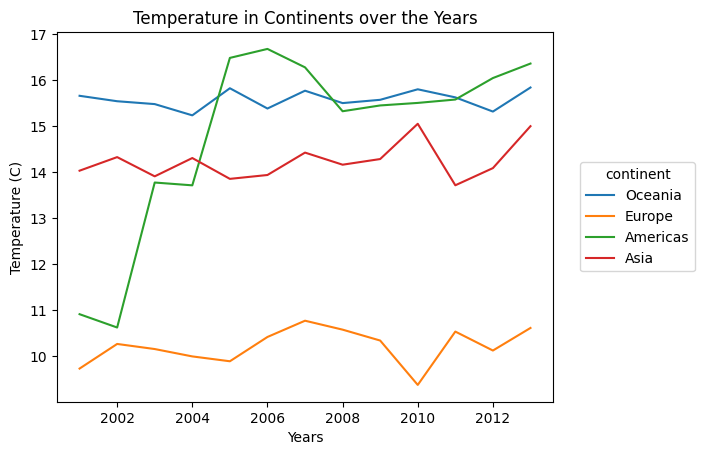

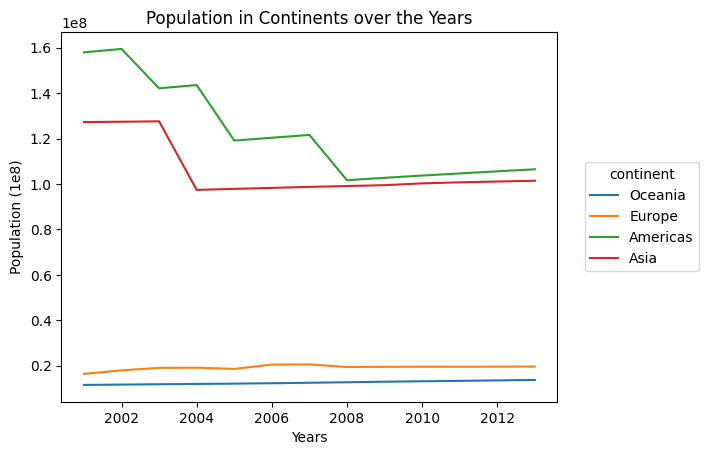

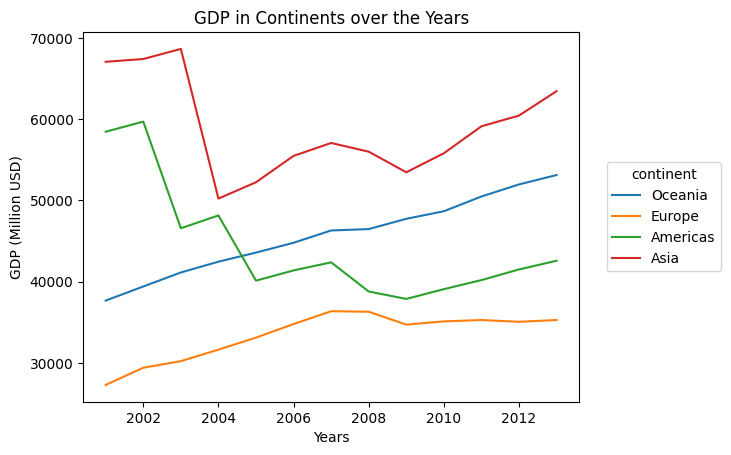

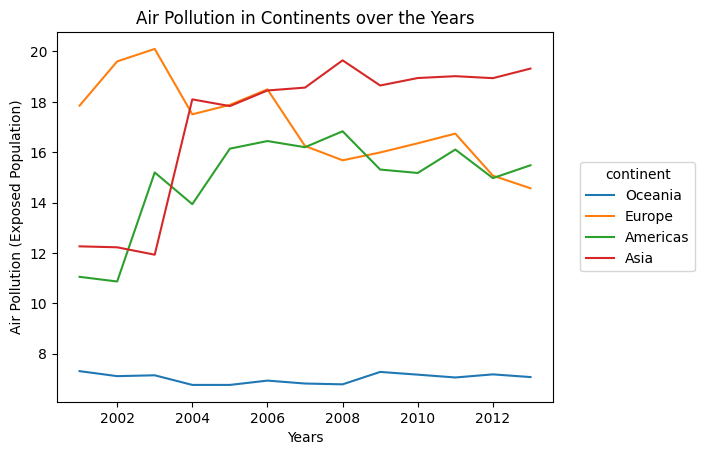

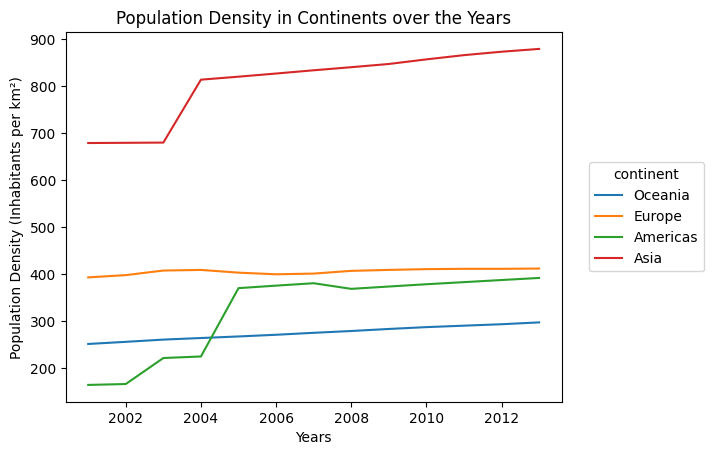

In [94]:
columns = ['Temperature', 'Population', 'GDP', 'Air Pollution', 'Population Density']
units = {'Temperature':'(C)', 'Population':'(1e8)', 'GDP':'(Million USD)', 'Air Pollution':'(Exposed Population)', 'Population Density': '(Inhabitants per km²)'}
for col in columns:
  plt.figure()
  g = sns.lineplot(data=df_all, x='Time', y=col, hue='continent', markers = True, errorbar=None)
  g.set(xlabel = "Years", ylabel = col + " " + units[col], title = col + " in Continents over the Years")
  sns.move_legend(g, "right", bbox_to_anchor=(1.3,0.5))

Based on these graphs, we see that Oceania has one of the highest temperature, but also has the lowest population, air pollution, and density with middle GDP.

Europe has the lowest temperature, along with population and GDP. It has high air pollution and middle density over the years.

Meanwhile, Americas temperature, air pollution, and density increased between 2001 and 2005, while its population and GDP decreased. Onwards, it has the one of highest temperature and population, with high air pollution and middle density over the years.

Lastly, Asia has the third highest temperature, with large population, highest GDP,  highest air pollution, and highest density.



Next, we are interested to see if there is any correlation. So we separate the numerical features and create a correlation matrix and heatmap.

In [95]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412 entries, 0 to 411
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Time                412 non-null    int64  
 1   country             412 non-null    object 
 2   LOCATION            412 non-null    object 
 3   continent           412 non-null    object 
 4   sub_region          412 non-null    object 
 5   Temperature         412 non-null    float64
 6   Population          412 non-null    float64
 7   GDP                 412 non-null    float64
 8   Air Pollution       412 non-null    float64
 9   Population Density  412 non-null    float64
dtypes: float64(5), int64(1), object(4)
memory usage: 35.4+ KB


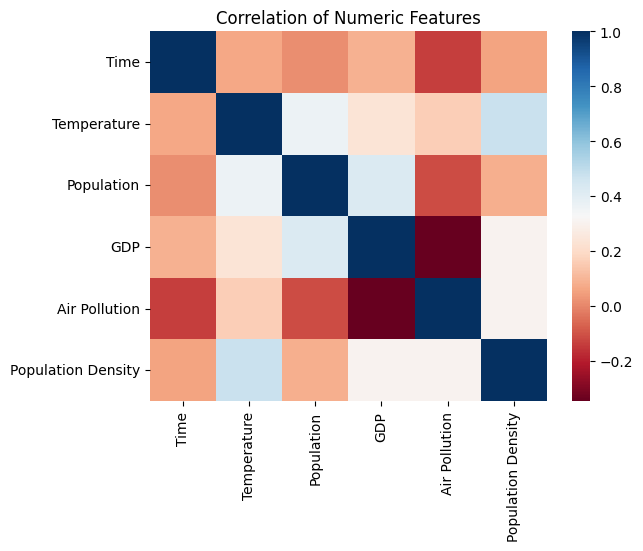

In [96]:
numerics_df = df_all.select_dtypes(include = ["float64", "int"])
corr_matrix = numerics_df.corr()
sns.heatmap(corr_matrix, cmap = "RdBu").set(title = "Correlation of Numeric Features")
plt.show()

Since there are a few number of features and correlation is moderate, we use unregularized linear regression.

The goal is to create a model to predict temperature, given continent location, population, GDP, air pollution, and people density as these factors can affect temperature of certain space. This is under the assumption that there is no seasonality and trending effect due to time and that there is simply a linear relationship between time and temperature.

To include continent location as a feature, we do one-hot encoding on continent. We then separate the feature columns from the temperature, fit a linear model on training data and test the model on testing data.

In [97]:
# One-hot encoding
df_all_one_hot = pd.get_dummies(data = df_all, columns = ['continent'])
df_all_one_hot.head()

,Time,country,LOCATION,sub_region,Temperature,Population,GDP,Air Pollution,Population Density,continent_Americas,continent_Asia,continent_Europe,continent_Oceania
0,2001,Australia,AUS,Australia and New Zealand,17.556173,19272100.0,53725.000,7.466667,261.7000,0,0,0,1
1,2001,Belgium,BEL,Western Europe,10.788226,10263400.0,35158.750,17.985714,455.3750,0,0,1,0
2,2001,Bulgaria,BGR,Eastern Europe,11.742250,8149470.0,9255.250,25.023529,187.2500,0,0,1,0
3,2001,Canada,CAN,Northern America,6.641357,31020900.0,51039.375,10.326923,182.9375,1,0,0,0
4,2001,Croatia,HRV,Southern Europe,11.786500,4295410.0,17334.500,21.042857,176.0000,0,0,1,0


In [98]:
features_columns = df_all_one_hot.drop(columns = ['country', 'LOCATION', 'sub_region', 'Temperature']).columns
features = df_all_one_hot[features_columns]
# features

temp = df_all_one_hot['Temperature']
# temp

seed = 42
x_train, x_test, y_train, y_test = train_test_split(features, temp, train_size = 0.8, random_state = seed)

In [99]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)
score = reg.score(x_test, y_test)
score

0.6306786864277857

The accuracy of the model against the training data is 63%.

To consider seasonality and trends in temperature, it is more appropriate to do a time series analysis.

# Time Series Analysis

The OECD dataset has used temperatures of 32C,38C and 46C to count days of heat stress on various levels. This is based on max temperatures. Our dataset has average temperatures where night time temperatures beging down the value. We are using over 32 degrees average to flag heat stress at any level for this analysis. This average tempearature higher than 89.6F which would normally guarantee a daytime high of around 100F given reasonable variations of 20F from day to night max to min. Simple analysis of philadelphia is done as an exploratory exercise

**Analysis for Philadelphia**

In [100]:
# Extract the data for Philadelphia 
df_temp_phily = df_temp_by_city_clean.loc[df_temp_by_city_clean['City']=="Philadelphia"]
#df_temp_phily = df_temp_phily.assign(date = pd.to_datetime(df_temp_phily['dt'],format ='%Y-%m-%d'))
#df_temp_phily['date'] = pd.to_datetime(df_temp_phily['dt'],format ='%Y-%m-%d' )
df_temp_phily.head()

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,drop_city,date
5584260,6.072,1.740,Philadelphia,United States,39.38N,74.91W,0,1743-11-01
5584261,11.672,2.088,Philadelphia,United States,39.38N,74.91W,0,1744-04-01
5584262,16.907,1.586,Philadelphia,United States,39.38N,74.91W,0,1744-05-01
5584263,22.366,1.531,Philadelphia,United States,39.38N,74.91W,0,1744-06-01
5584264,23.642,1.371,Philadelphia,United States,39.38N,74.91W,0,1744-07-01


Test time series forecasting on Phily data. First plot the average temperatures over the full duration

Text(0.5, 1.0, 'Average Temperature in Philadelphia From 1760 to 2013')

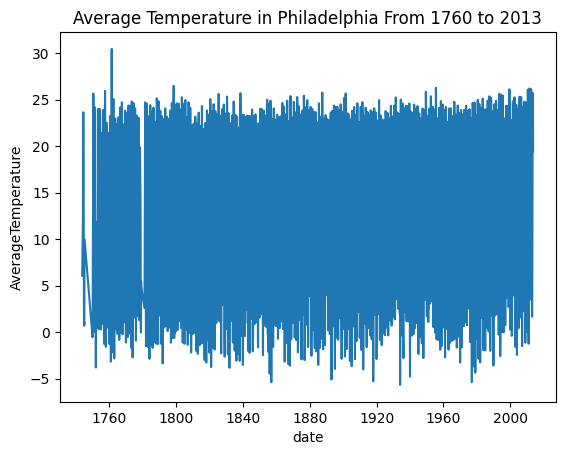

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.ylabel("AverageTemperature")
plt.xlabel("date")
plt.plot(df_temp_phily.date,df_temp_phily.AverageTemperature)
plt.title("Average Temperature in Philadelphia From 1760 to 2013")

Using Sarimax from Stat Models requires a stationarity test first

It is important to check if the time series data here is stationary or not. The Augmented Dickey Fuller test is used to do this test. The null hypothesis is that the data is not shifting over time. If the p-value of the test is 0.05 we accept the null hypothesis


In [102]:
# Dickey fuller test requires handling the gaps in the data.
phily_nan_df = df_temp_by_city.loc[df_temp_by_city['AverageTemperature'].isna() & df_temp_by_city['City'] == "Philadelphia"]
#phily_nan_df.head()
phily_nan_df.tail()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,drop_city


Since the last missing value was in 1780, we simply start the analysis from 1800 in the orginal data. The clean data set removed the Nan values . Even so we start from 1800 for clean treatment of the statistics

In [103]:
df_temp_phily = df_temp_phily.loc[df_temp_phily['date']>pd.to_datetime('1800-01-01', format ='%Y-%m-%d') ]
df_temp_phily.head()


,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,drop_city,date
5584815,0.358,3.456,Philadelphia,United States,39.38N,74.91W,0,1800-02-01
5584816,3.875,3.848,Philadelphia,United States,39.38N,74.91W,0,1800-03-01
5584817,12.343,2.269,Philadelphia,United States,39.38N,74.91W,0,1800-04-01
5584818,15.931,1.859,Philadelphia,United States,39.38N,74.91W,0,1800-05-01
5584819,21.699,2.342,Philadelphia,United States,39.38N,74.91W,0,1800-06-01


Split the data into Test and Training data for SARIMAX and then do ADF on the Training data


In [104]:
train = df_temp_phily[df_temp_phily['date'] < pd.to_datetime("2008-12-31", format='%Y-%m-%d')]
test=   df_temp_phily[df_temp_phily['date'] > pd.to_datetime("2008-12-31",format = '%Y-%m-%d')]

The Augmented Dickey Fuller Analysis looks for trends and helps us make sure the data is stationary before time series analysis. The p-value is very much less than 0.05 and this indicates that the temperatures are stationary. We can reject the null hypothesis

In [105]:
from statsmodels.tsa.stattools import adfuller
print("Results of Augmented Dickey Fuller test on Phily data ")
phily_adf_test = adfuller(train['AverageTemperature'],autolag='AIC')
print(phily_adf_test)
phily_adf_output = pd.Series(phily_adf_test[0:4],index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in phily_adf_test[4].items():
    phily_adf_output['Critical Value (%s)'%key] = value
print(phily_adf_output)


Results of Augmented Dickey Fuller test on Phily data 
(-4.906362508834178, 3.3893388542853547e-05, 26, 2480, {'1%': -3.4329895489772104, '5%': -2.8627061345839557, '10%': -2.5673907792989072}, 9415.184460008075)
Test Statistic                   -4.906363
p-value                           0.000034
#Lags Used                       26.000000
Number of Observations Used    2480.000000
Critical Value (1%)              -3.432990
Critical Value (5%)              -2.862706
Critical Value (10%)             -2.567391
dtype: float64


We can also do component analysis to see if there is a trend component to the data and a seasonality. The STL module does that and we plot the 3 components below. The setting of seasonal=13 eliminates the seasonal variation. There is a slight trend in the data seen towards the end from a visual inspection of values but this may not be sufficient to figure on the ADF test above

date
1800-02-01    11.742490
1800-03-01    11.768956
1800-04-01    11.795846
1800-05-01    11.824565
1800-06-01    11.855732
                ...    
2008-08-01    12.715849
2008-09-01    12.601475
2008-10-01    12.481873
2008-11-01    12.357327
2008-12-01    12.228865
Name: trend, Length: 2507, dtype: float64


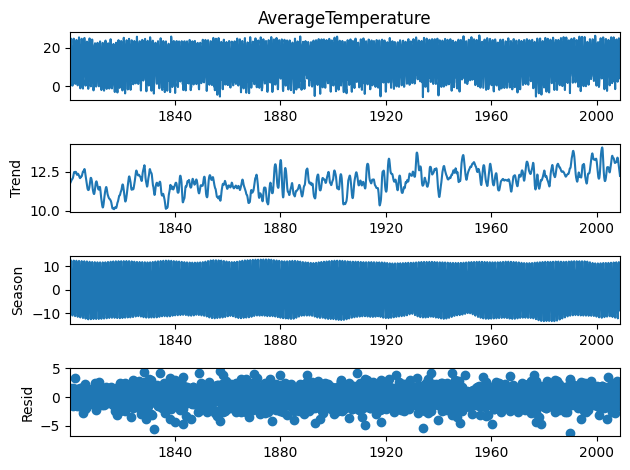

In [106]:
from statsmodels.tsa.seasonal import STL
#train.head(24)
train_ph_av = train.set_index(train.date)
train_stl = pd.Series(train_ph_av['AverageTemperature'],index=train_ph_av.index)
#train_stl.describe()
stl = STL(train_stl,seasonal=13)
result = stl.fit()
fig = result.plot()
fig.show()
print(result.trend)

The SARIMAX model does the seasonal adjusted Moving Average Auto Regression analysis. We take the data from 1800 to 2008 as training data and the rest through 2013 as Test data. The we run the model and predict the same period as the test data.

In [107]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
#train = df_temp_phily[df_temp_phily['date'] < pd.to_datetime("2008-12-31", format='%Y-%m-%d')]
#test=   df_temp_phily[df_temp_phily['date'] > pd.to_datetime("2008-12-31",format = '%Y-%m-%d')]

y_temp = train['AverageTemperature']
smax_model = SARIMAX(y_temp,order=(1,1,1),seasonal_order = (1,1,1,12))
smax_model = smax_model.fit()
y_temp = smax_model.get_forecast(len(test.index))
y_temp_df = y_temp.conf_int(alpha = 0.05)
y_temp_df['Predicted_temp'] = smax_model.predict(start = y_temp_df.index[0],end = y_temp_df.index[-1])
y_temp_df.index = test.index

#y_temp_df = y_temp_df.merge(test[['date']] ,left_on = 'index',right_on = 'index', how = 'inner')
y_temp_df.head()




/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,lower AverageTemperature,upper AverageTemperature,Predicted_temp
5587322,-1.462505,4.610158,1.573826
5587323,-0.902367,5.277226,2.187430
5587324,3.224777,9.413155,6.318966
5587325,8.404760,14.596204,11.500482
5587326,13.994920,20.188768,17.091844


Join the two datasets: prediction dataset(y_temp_df)  and test dataset(test) for plotting. 

In [108]:
y_temp_df = y_temp_df.rename(index={0:'index'})
y_temp_df =y_temp_df.merge(test[['date','AverageTemperature']],left_index=True,right_index =True,how='inner')
#y_temp_df = y_temp_df.rename(columns = {"date_x": "date",})
#y_temp_df = y_temp_df.drop(columns = ['date_y','AverageTemperature_y','AverageTemperature_x'])#
y_temp_df.head()


,lower AverageTemperature,upper AverageTemperature,Predicted_temp,date,AverageTemperature
5587322,-1.462505,4.610158,1.573826,2009-01-01,-1.127
5587323,-0.902367,5.277226,2.187430,2009-02-01,2.880
5587324,3.224777,9.413155,6.318966,2009-03-01,5.608
5587325,8.404760,14.596204,11.500482,2009-04-01,11.993
5587326,13.994920,20.188768,17.091844,2009-05-01,16.875


Plot the predicted temperature and the actual. The model fits in the shape of the actual data well except for the peak temperatures being under consistently

<ipython-input-109-0a436a77dea4>:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo--" (-> color='b'). The keyword argument will take precedence.
  plt.plot(y_temp_df['date'], y_temp_df['Predicted_temp'], 'bo--' ,color = 'blue',linewidth = 2,label ="Predicted temp")
<ipython-input-109-0a436a77dea4>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(y_temp_df['date'], y_temp_df['AverageTemperature'], 'ro' ,color = 'red',linewidth = 3,linestyle = 'solid',label ="Actual temp")


Text(0.5, 1.0, 'Predicted value and Actual Average value from 2009 to 2013-SARIMAX-No Trend')

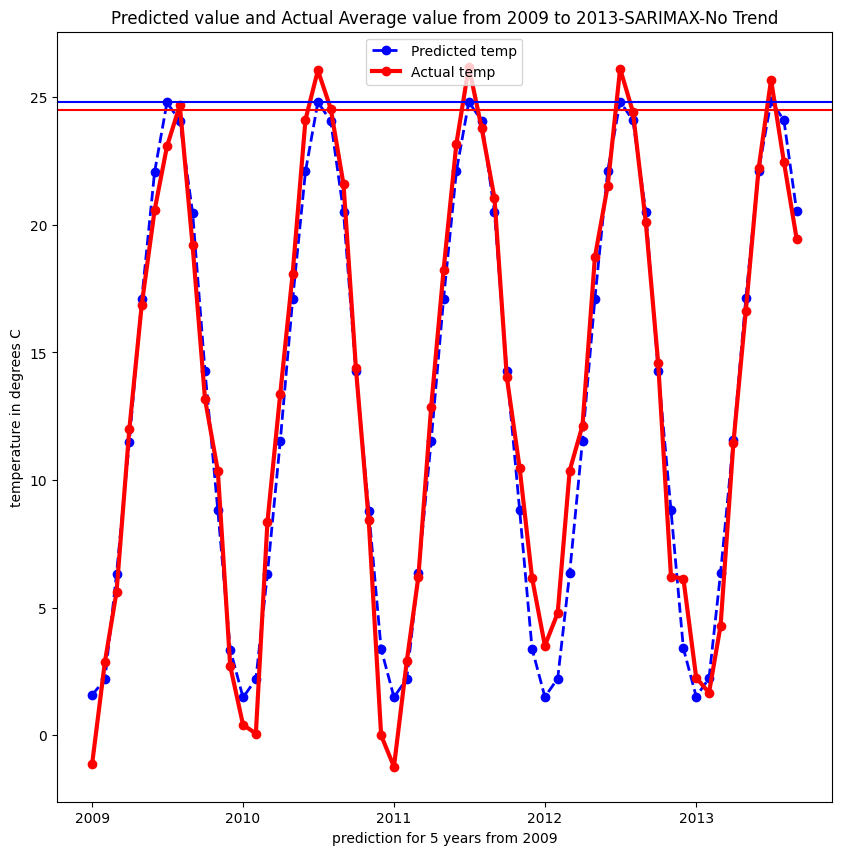

In [109]:
plt.figure(figsize =(10,10))
plt.plot(y_temp_df['date'], y_temp_df['Predicted_temp'], 'bo--' ,color = 'blue',linewidth = 2,label ="Predicted temp")
plt.plot(y_temp_df['date'], y_temp_df['AverageTemperature'], 'ro' ,color = 'red',linewidth = 3,linestyle = 'solid',label ="Actual temp")
plt.legend(loc='upper center')
plt.axhline(y=24.5,color ='red')
plt.axhline(y=24.8,color ='blue')
plt.ylabel("temperature in degrees C")
plt.xlabel("prediction for 5 years from 2009")
plt.title ("Predicted value and Actual Average value from 2009 to 2013-SARIMAX-No Trend")


Now that we have a prediction we need to save the mean square error of the prediction

In [110]:
from sklearn.metrics import mean_squared_error as mse
import numpy as np
sarimax_rmse =np.sqrt(mse(test['AverageTemperature'],y_temp_df['Predicted_temp']))
print("Root Mean Square Error Value of Temperature Prediction",sarimax_rmse)

Root Mean Square Error Value of Temperature Prediction 1.533521776733172


We now average the temperatures for each month in a decade and repeat all the analysis. The goal is to see if there is any difference . From a prediction standpoint, predicting 2 decades out would be a good exercise and using average temperatures here is a better data source for a longer term prediction

In [111]:
def get_decade(year):
    return year[0:3]+'0s'
df_phily_decade = df_temp_phily.assign(Year = df_temp_phily.date.dt.year.astype(str))
df_phily_decade = df_phily_decade.assign(Decade = df_phily_decade['Year'].apply(get_decade))
df_phily_decade = df_phily_decade.assign(Month = df_phily_decade.date.dt.month)
df_phily_decade = df_phily_decade.groupby(['City','Latitude','Longitude','Decade','Month']).mean('AverageTemperature').reset_index()
df_phily_decade.head()


,City,Latitude,Longitude,Decade,Month,AverageTemperature,AverageTemperatureUncertainty,drop_city
0,Philadelphia,39.38N,74.91W,1800s,1,-0.062556,3.097444,0.0
1,Philadelphia,39.38N,74.91W,1800s,2,1.300100,2.829800,0.0
2,Philadelphia,39.38N,74.91W,1800s,3,4.758600,3.319600,0.0
3,Philadelphia,39.38N,74.91W,1800s,4,10.573800,2.835900,0.0
4,Philadelphia,39.38N,74.91W,1800s,5,16.086300,2.429700,0.0


Create new Traning and Test datasets for decade analysis

In [112]:
train_decade_phily = df_phily_decade.loc[df_phily_decade['Decade'] <= "1970s"]
test_decade_phily = df_phily_decade.loc[df_phily_decade['Decade'] > '1970s']

ADF analysis for decade averages
Here the p value is > 0.05 and seems to indicate the series is not stationary

In [113]:
from statsmodels.tsa.stattools import adfuller
print("Results of Augmented Dickey Fuller test on Phily data ")
phily_adf_test2 = adfuller(train_decade_phily['AverageTemperature'],autolag='AIC')
print(phily_adf_test2)
phily_adf_output2 = pd.Series(phily_adf_test2[0:4],index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in phily_adf_test2[4].items():
    phily_adf_output2['Critical Value (%s)'%key] = value
print(phily_adf_output2)

Results of Augmented Dickey Fuller test on Phily data 
(-1.6570163998909662, 0.4533837824978702, 14, 201, {'1%': -3.4633090972761744, '5%': -2.876029332045744, '10%': -2.5744932593252643}, 376.5902897712899)
Test Statistic                  -1.657016
p-value                          0.453384
#Lags Used                      14.000000
Number of Observations Used    201.000000
Critical Value (1%)             -3.463309
Critical Value (5%)             -2.876029
Critical Value (10%)            -2.574493
dtype: float64


Decomposition Analysis on the data does not show a trend for decade averages. 

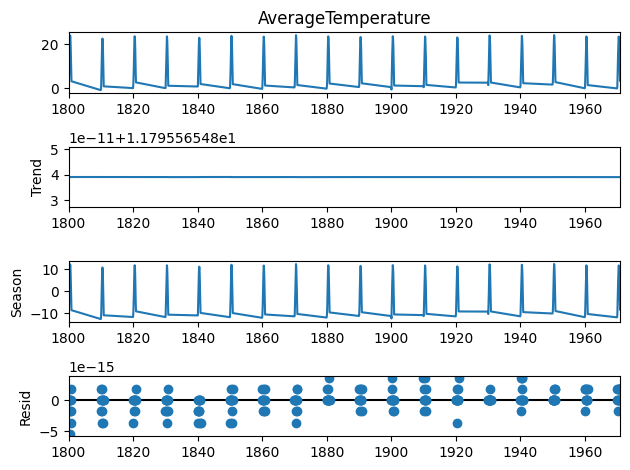

In [114]:
def get_year(decade):
  base_year = decade[0:4]
  year = int(base_year)
  return year
from statsmodels.tsa.seasonal import STL
from pandas.plotting import register_matplotlib_converters
train_decade_phily.head()
phily_decade = train_decade_phily.assign(year = lambda x : x.Decade.apply(get_year))
phily_decade = phily_decade.assign(date = pd.to_datetime(dict(year =phily_decade.year,month = phily_decade.Month,day = 1 )))
phily_decade = phily_decade.set_index('date')
phily_decade.head(24)
phily_decade_stl = pd.Series(phily_decade['AverageTemperature'],index=phily_decade.index)
phily_decade_stl.describe()
phstl = STL(phily_decade_stl,period = len(train_decade_phily))
phresult = phstl.fit()
fig = phresult.plot()
fig.show()

SARIMAX on the decade averages

In [115]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
#train_decade_phily = df_phily_decade.loc[df_phily_decade['Decade'] <= "1970s"]
#test_decade_phily = df_phily_decade.loc[df_phily_decade['Decade'] > '1970s']
y_temp_d = train_decade_phily['AverageTemperature']
smax_model = SARIMAX(y_temp_d,order=(1,1,1),seasonal_order = (1,1,1,12))
smax_model = smax_model.fit()
y_temp_d = smax_model.get_forecast(len(test.index))
y_temp_df_d = y_temp_d.conf_int(alpha = 0.05)
y_temp_df_d['Predicted_temp'] = smax_model.predict(start = y_temp_df_d.index[0],end = y_temp_df_d.index[-1])
y_temp_df.index = test.index
y_temp_df_d = y_temp_df_d.rename(index={0:'index'})
y_temp_df_d =y_temp_df_d.merge(test_decade_phily[['Decade','Month','AverageTemperature']],left_index=True,right_index =True,how = "inner")
y_temp_df_d = y_temp_df_d.assign(Monthstr = lambda x: x.Month.astype(str))
y_temp_df_d = y_temp_df_d.assign(DecadeMonth = lambda x: x.Decade+x.Monthstr)

Comparing the prediction with the actual values for the test range below.

<ipython-input-116-a825d2def687>:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo--" (-> color='b'). The keyword argument will take precedence.
  plt.plot(y_temp_df_d.DecadeMonth, y_temp_df_d['Predicted_temp'],'bo--', color= 'blue' ,label ='Predicted temp')
<ipython-input-116-a825d2def687>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(y_temp_df_d.DecadeMonth, y_temp_df_d['AverageTemperature'],'ro',linestyle ='solid', color= 'red' ,label ='Actual temp')


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47],
 [Text(0, 0, '1980s1'),
  Text(1, 0, '1980s2'),
  Text(2, 0, '1980s3'),
  Text(3, 0, '1980s4'),
  Text(4, 0, '1980s5'),
  Text(5, 0, '1980s6'),
  Text(6, 0, '1980s7'),
  Text(7, 0, '1980s8'),
  Text(8, 0, '1980s9'),
  Text(9, 0, '1980s10'),
  Text(10, 0, '1980s11'),
  Text(11, 0, '1980s12'),
  Text(12, 0, '1990s1'),
  Text(13, 0, '1990s2'),
  Text(14, 0, '1990s3'),
  Text(15, 0, '1990s4'),
  Text(16, 0, '1990s5'),
  Text(17, 0, '1990s6'),
  Text(18, 0, '1990s7'),
  Text(19, 0, '1990s8'),
  Text(20, 0, '1990s9'),
  Text(21, 0, '1990s10'),
  Text(22, 0, '1990s11'),
  Text(23, 0, '1990s12'),
  Text(24, 0, '2000s1'),
  Text(25, 0, '2000s2'),
  Text(26, 0, '2000s3'),
  Text(27, 0, '2000s4'),
  Text(28, 0, '2000s5'),


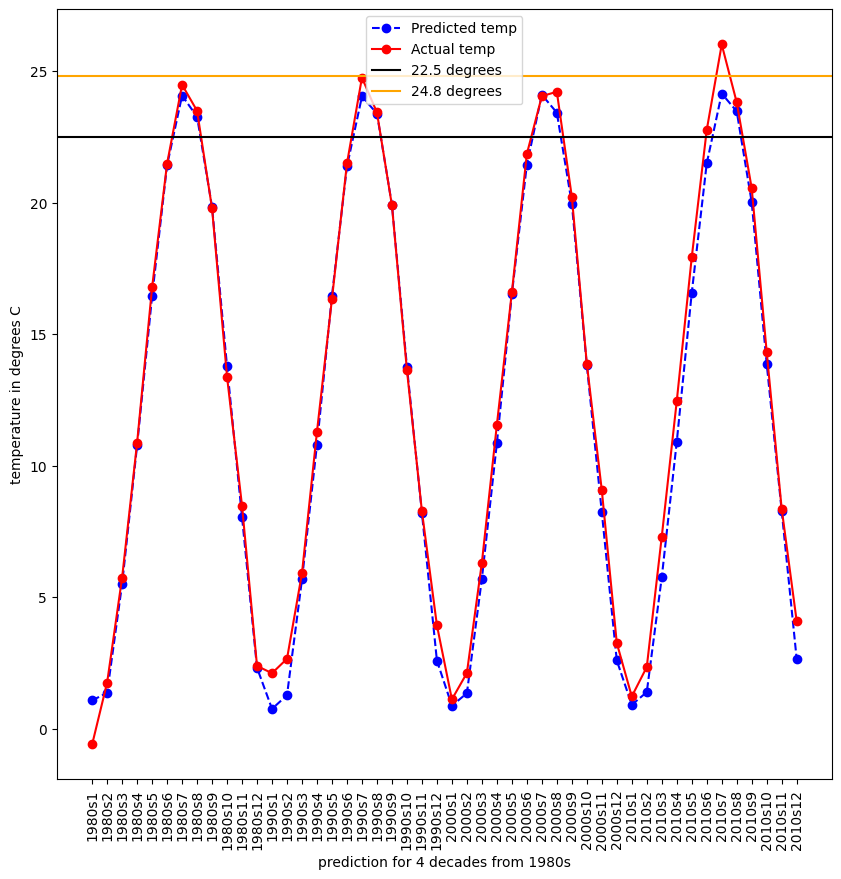

In [116]:
plt.figure(figsize =(10,10))
plt.plot(y_temp_df_d.DecadeMonth, y_temp_df_d['Predicted_temp'],'bo--', color= 'blue' ,label ='Predicted temp')
plt.plot(y_temp_df_d.DecadeMonth, y_temp_df_d['AverageTemperature'],'ro',linestyle ='solid', color= 'red' ,label ='Actual temp')
plt.axhline(y=22.5,color ='black',label = "22.5 degrees ")
plt.axhline(y=24.8,color ='orange',label = "24.8 degrees")
plt.legend(loc = 'upper center')
plt.ylabel("Temperature in degrees C")
plt.xlabel("Prediction for 4 decades from 1980s")
plt.xticks(rotation = 90)

Based on the class slides, we also repeat the analysis for rolling means and rolling standard deviation to look for trends. Visually rolling mean seems to have a trend but ADF does not find it.
Step 1 calculate Rolling Mean and Rolling STD, Window is 12 because of the 1 year seasonality

In [117]:
rolmean_ph = pd.Series.rolling(train['AverageTemperature'],center = False, window = 12).mean()
rol_std_ph = pd.Series.rolling(train['AverageTemperature'],center = False,window = 12).std()

Drop the Nan values that occur in the beginning

In [118]:
from math import trunc
def get_year(rownumber):
  years_no = trunc(rownumber /12 ) 
  year = 1800+ years_no
  return year
def get_month(rownumber):
  years_no = trunc(rownumber /12 ) 
  month = rownumber - 12*years_no +1
  return month
rolmean_ph_df = rolmean_ph.to_frame()
rolmean_ph_df = rolmean_ph_df.rename(columns = {0:"index",1:'AverageTemperature'})
rolmean_ph_df = rolmean_ph_df.dropna()
rolmean_ph_df = rolmean_ph_df.assign(rownumber =    range(len(rolmean_ph_df)))
rolmean_ph_df = rolmean_ph_df.assign(approxdate = lambda x: x.rownumber/12+1800)
rolmean_ph_df = rolmean_ph_df.assign(year = lambda x: x.rownumber.apply(get_year))
rolmean_ph_df = rolmean_ph_df.assign(month = lambda x:x.rownumber.apply(get_month))
rolmean_ph_df = rolmean_ph_df.assign(day  = 1)
rolmean_ph_df = rolmean_ph_df.assign(date = pd.to_datetime(dict(year = rolmean_ph_df.year,month = rolmean_ph_df.month, day = rolmean_ph_df.day)))
#rolmean_ph_df.tail(24)
rol_std_ph_df = rol_std_ph.to_frame()
rol_std_ph_df = rol_std_ph_df.rename(columns = {rol_std_ph_df.columns[0]:'AvTempStd-Dev'})
rol_std_ph_df = rol_std_ph_df.dropna()
rol_std_ph_df = rol_std_ph_df.assign(rownumber =    range(len(rol_std_ph_df)))
rol_std_ph_df = rol_std_ph_df.assign(approxdate =   lambda x : x.rownumber/12+1800)
#rol_std_ph_df.tail(24)

Plot the rolling mean and the roling standard deviation

Text(0.5, 1.0, 'Rolling Mean and Rolling Standard Deviation plot for Philadelphia')

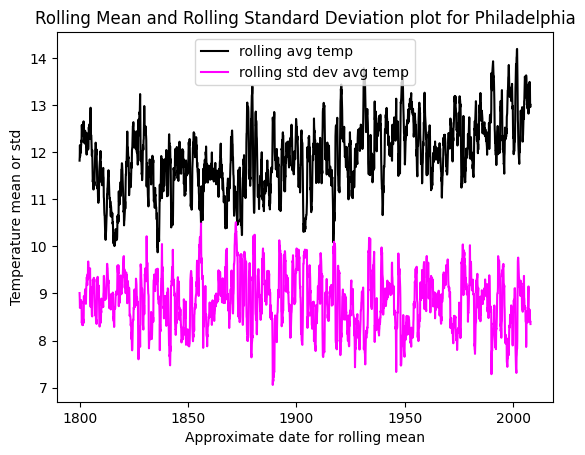

In [141]:
plt.plot(rolmean_ph_df['approxdate'],rolmean_ph_df['AverageTemperature'],color = 'black',label = 'rolling avg temp')
plt.plot(rol_std_ph_df['approxdate'],rol_std_ph_df['AvTempStd-Dev'],color = 'magenta',label = 'rolling std dev avg temp')
plt.legend(loc='upper center')
plt.xlabel('Approximate date for rolling mean')
plt.ylabel('Temperature mean or std')
plt.title('Rolling Mean and Rolling Standard Deviation plot for Philadelphia')

Component analysis on the rolling mean. We can see that the rolling mean has an upward trend on average temperature even though the original data did not

date
1800-01-01    11.856894
1800-02-01    11.896323
1800-03-01    11.936098
1800-04-01    11.976343
1800-05-01    12.017077
                ...    
2007-08-01    13.238720
2007-09-01    13.241480
2007-10-01    13.243522
2007-11-01    13.244460
2007-12-01    13.244116
Name: trend, Length: 2496, dtype: float64


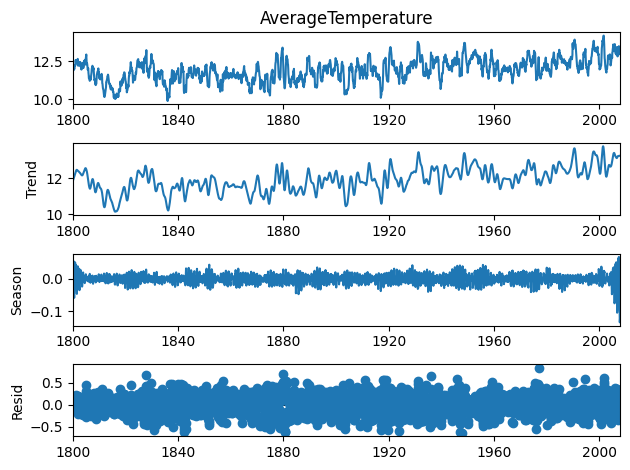

In [120]:
from statsmodels.tsa.seasonal import STL
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

rolmean_ph_df = rolmean_ph_df.set_index(rolmean_ph_df.date)
rolmean_ph_df.head()
rolmean_stl = pd.Series(rolmean_ph_df['AverageTemperature'],index=rolmean_ph_df.date)
#rolmean_stl.describe()
stl = STL(rolmean_stl,seasonal=13)
result_rolmean = stl.fit()
fig = result_rolmean.plot()
fig.show()
print(result_rolmean.trend)

ADF on rolling mean . The p value is less than 0.05 and we can conclude the rolling mean is probably stationary

In [121]:
from statsmodels.tsa.stattools import adfuller
print("Results of Augmented Dickey Fuller test on Phily data Rolling mean ")
phily_adf_test_rm = adfuller(rolmean_ph_df['AverageTemperature'],autolag='AIC')
print(phily_adf_test_rm)
phily_adf_output_rm = pd.Series(phily_adf_test_rm[0:4],index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in phily_adf_test_rm[4].items():
    phily_adf_output_rm['Critical Value (%s)'%key] = value
print(phily_adf_output_rm)

Results of Augmented Dickey Fuller test on Phily data Rolling mean 
(-3.9361367277403683, 0.0017844236515306311, 25, 2470, {'1%': -3.4330002465470844, '5%': -2.862710858596359, '10%': -2.567393294431969}, -2411.4760872788647)
Test Statistic                   -3.936137
p-value                           0.001784
#Lags Used                       25.000000
Number of Observations Used    2470.000000
Critical Value (1%)              -3.433000
Critical Value (5%)              -2.862711
Critical Value (10%)             -2.567393
dtype: float64


Philadelphia max temperature analysis. As a first step we extract the maximum temperature in each year since 1900

Text(0.5, 1.0, "Plot of Philadelphia's max avg month temperature each year after 1900")

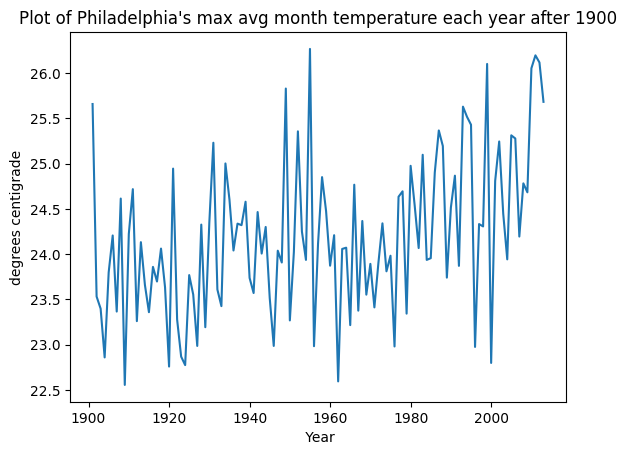

In [145]:
df_temp_phily_yr = df_temp_phily.assign(year = df_temp_phily['date'].dt.year)
df_temp_phily_max = df_temp_phily_yr.groupby(['year'])['AverageTemperature'].max().reset_index()
df_temp_phily_max.head()
df_temp_phily_max_recent = df_temp_phily_max.loc[df_temp_phily_max['year'] > 1900]
plt.xlabel(" Year")
plt.ylabel("degrees centigrade")
plt.plot(df_temp_phily_max_recent['year'],df_temp_phily_max_recent['AverageTemperature'])
plt.title("Plot of Philadelphia's max avg month temperature each year after 1900")

In this step, we run the ADF analysis to see if the data is stationary. We find that it is not stationary.

In [123]:
phily_adf_test_max_recent = adfuller(df_temp_phily_max_recent['AverageTemperature'],autolag = 'AIC')
print(phily_adf_test_max_recent)
phily_adf_output_max_recent = pd.Series(phily_adf_test_max_recent[0:4],index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in phily_adf_test_max_recent[4].items():
    phily_adf_output_max_recent['Critical Value (%s)'%key] = value
print(phily_adf_output_max_recent)

(-0.4709112027287124, 0.8975690728754404, 5, 107, {'1%': -3.492995948509562, '5%': -2.888954648057252, '10%': -2.58139291903223}, 240.1056091132555)
Test Statistic                  -0.470911
p-value                          0.897569
#Lags Used                       5.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


In the next step, we try component analysis to see if the trend is easily extractable but it is not.

113


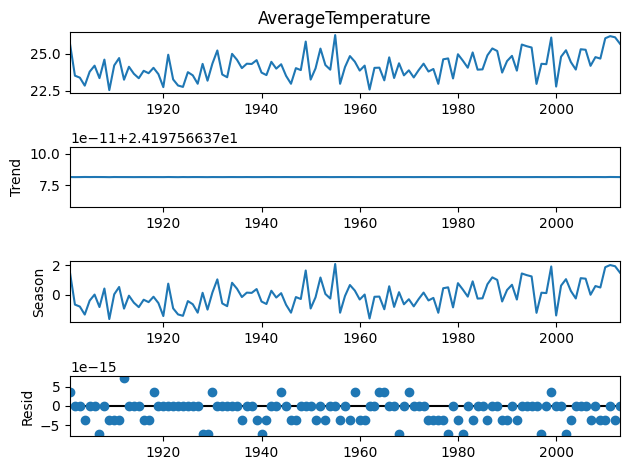

,year,AverageTemperature,date
date,,,
1901-01-01,1901,25.659,1901-01-01
1902-01-01,1902,23.531,1902-01-01
1903-01-01,1903,23.397,1903-01-01
1904-01-01,1904,22.858,1904-01-01
1905-01-01,1905,23.798,1905-01-01


In [124]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

df_temp_phily_max_recent = df_temp_phily_max_recent.assign(date = pd.to_datetime(dict(year = df_temp_phily_max_recent.year,month=1,day=1)))
df_temp_phily_max_recent = df_temp_phily_max_recent.set_index(df_temp_phily_max_recent.date)
#df_temp_phily_max_recent.head()
phily_max_stl = pd.Series(data = df_temp_phily_max_recent['AverageTemperature'],index = df_temp_phily_max_recent.date)

#phily_max_stl.head()
#df_temp_phily_max_recent.head()
stl_max = STL(phily_max_stl,period=113)
result_phily_max = stl_max.fit()
result_phily_max.plot()
print(len(df_temp_phily_max_recent))
plt.show()
#print(result_phily_max.trend)
df_temp_phily_max_recent.head()

Next step, we break the data into training and testing sets.

In [125]:
df_temp_phily_max_recent.head()
train_ph_max = df_temp_phily_max_recent.loc[df_temp_phily_max_recent['year']<2000]
test_ph_max = df_temp_phily_max_recent.loc[df_temp_phily_max_recent['year']>=2000]
train_ph_max.head()

,year,AverageTemperature,date
date,,,
1901-01-01,1901,25.659,1901-01-01
1902-01-01,1902,23.531,1902-01-01
1903-01-01,1903,23.397,1903-01-01
1904-01-01,1904,22.858,1904-01-01
1905-01-01,1905,23.798,1905-01-01


Next, we train the ARIMA model and get the predictions. We use p,d,q = 3,0,3 and trend = 'ct' after experimentation. Please note, the addition of the trend term is added to make the result closer to observed data. Even with the trend, we will see the prediction beyond 2000 falls short of observed maximum temperatures.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:     AverageTemperature   No. Observations:                   99
Model:                 ARIMA(3, 0, 3)   Log Likelihood                -106.310
Date:                Sat, 29 Apr 2023   AIC                            230.620
Time:                        05:16:16   BIC                            253.976
Sample:                    01-01-1901   HQIC                           240.070
                         - 01-01-1999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.6281      0.198    119.458      0.000      23.240      24.016
x1             0.0091      0.003      2.982      0.003       0.003       0.015
ar.L1          0.4780      0.434      1.102      0.2

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


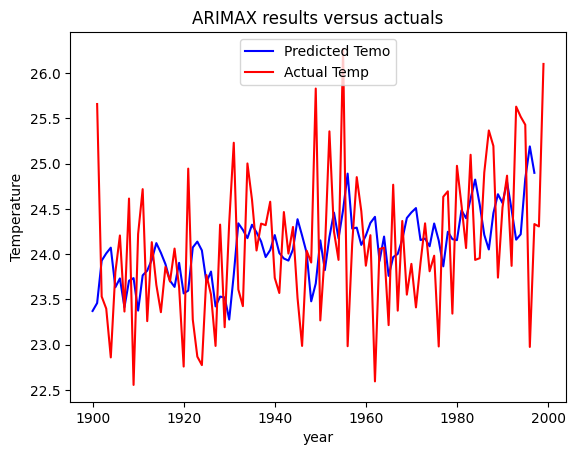

In [126]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_ph_max['AverageTemperature'],order = (3,0,3),trend ='ct')
results_ph_max = model.fit()
print(results_ph_max.summary())
fitted_series_df = pd.Series(results_ph_max.fittedvalues).to_frame()
# drop the first row which is a zero
fitted_series_df = fitted_series_df.tail(-1)
# add back the year information
series_length = len(fitted_series_df)
fitted_series_df = fitted_series_df.assign(year = range(1900,1900+series_length))
fitted_series_df = fitted_series_df.rename(columns = {0:"Predicted_Temperature"})
# plot the two series
plt.title("ARIMAX results versus actuals")
plt.ylabel("Temperature")
plt.xlabel("Year")
plt.plot(fitted_series_df['year'],fitted_series_df['Predicted_Temperature'],color = 'blue',label= "Predicted Temperature")
plt.plot(train_ph_max['year'],train_ph_max['AverageTemperature'],color = 'red',label = "Actual Temperature")
plt.legend(loc='upper center')

Next, we predict 2000-2013 where we have the data. Then we will plot and compare the actuals. The fitting of a trend in the training data still underestimates the rise of observed temperatures. 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14 entries, 2001-01-01 to 2014-01-01
Freq: AS-JAN
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   predicted_mean  14 non-null     float64
 1   year            14 non-null     int64  
dtypes: float64(1), int64(1)
memory usage: 336.0 bytes


<ipython-input-152-55584da4d326>:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo--" (-> color='b'). The keyword argument will take precedence.
  plt.plot(predict_ph_max_df.year,predict_ph_max_df.predicted_mean,"bo--",color = 'blue',label = "predicted temp")
<ipython-input-152-55584da4d326>:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(test_ph_max['year'],test_ph_max['AverageTemperature'],"ro",color = 'red',linestyle='solid',label = "predicted temp")


Text(0.5, 1.0, "Predicted Annual Max Average Monthly Temperature vs Actual Philadelphia's Temperature")

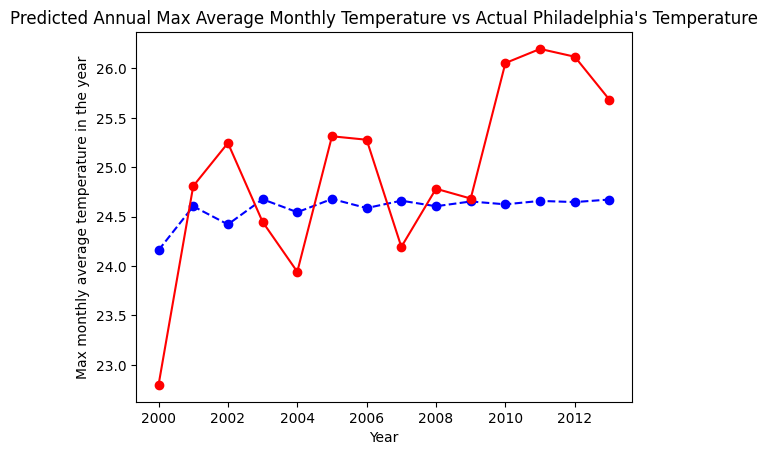

In [152]:
# Predict the next 44 years
start_index = 99
predict_length = 14
end_index = start_index + predict_length
start_year = 2000
predict_ph_max = results_ph_max.predict(start_index,end_index)
# Convert to dataframe
predict_ph_max_df = predict_ph_max.to_frame()
# Drop the first row
predict_ph_max_df = predict_ph_max_df.tail(-1)
end_predict = start_year + predict_length
predict_ph_max_df = predict_ph_max_df.assign(year = range(start_year,end_predict))
predict_ph_max_df.info()
plt.plot(predict_ph_max_df.year,predict_ph_max_df.predicted_mean,"bo--",color = 'blue',label = "predicted temp")
plt.plot(test_ph_max['year'],test_ph_max['AverageTemperature'],"ro",color = 'red',linestyle='solid',label = "predicted temp")
plt.xlabel("Year")
plt.ylabel("Max monthly average temperature in the year")
plt.title("Predicted Annual Max Average Monthly Temperature vs Actual Philadelphia's Temperature")

Analysis of the above plot above shows that even the trend detected by ARIMAX from the training data 1900 to 1999 cannot account for the maximum temperature rise in philadelphia. Full modeling may need to use training data from past 1950 to account for the actual trend or do exponential weighting and look at non linear trends. For a more meaningful model, we need explanatory factors in the dataset and we are pausing the pure time series at this point.

The Analysis Above does not show non stationary behavior in any of the values except for ADF o on the maximum temperature in a year. This analysis will be extended city by city for the whole dataset and the results captured in a file for further analysis in the next section.

# Analysis of the Maximum Temperatures of all Cities after Testing Stationary nature of all temperatures for first 25 samples in the full dataset
In this section, we select each city and test the prediction model and document the results in a dataframe and save to a csv file.
Then we analyze the cities in aggregate to document the conclusions

In [128]:
temp_cities_df = df_temp_by_city_clean[['Country','City','Latitude','Longitude']].drop_duplicates()
#temp_cities_df.insert(0,'CityNo',range(len(temp_cities_df)))
temp_cities_list = temp_cities_df.values.tolist()
print(temp_cities_list[0])

['Denmark', 'Århus', '57.05N', '10.33E']


We analyze the full data of the city regardless of the length of time and we analyze the average temperature for all months. As in the case of Philadelphia we find below that the time series is stationary for all the cities.

In [129]:
results_dict = dict()
test_len = 25
for i in range(test_len):
  curr_country = temp_cities_list[i][0]
  curr_city = temp_cities_list[i][1]
  curr_latitude = temp_cities_list[i][2]
  curr_longitude = temp_cities_list[i][3]
  df_temp_curr_city = df_temp_by_city_clean.loc[(df_temp_by_city_clean['Country']== curr_country)  & (df_temp_by_city_clean['City']== curr_city) ]
  curr_city_adf = adfuller(df_temp_curr_city['AverageTemperature'],autolag = 'AIC')
  country_city = tuple([curr_country,curr_city,curr_latitude,curr_longitude])
  results_dict[country_city] = curr_city_adf
  non_stationary = []
  if curr_city_adf[1]> 0.05:
    non_stationary.append(country_city)
print("non stationary Average temp cities  in ADF test",len(non_stationary),"out of",test_len)  


non stationary Average temp cities  in ADF test 0 out of 25


The analysis of the full history of the first 25 cities shows the same results as Philadelphia. The entire time series seems stationary on the ADF test for time series. Below we shift the analysis to max temperatures after 1900 as in the case of Philadelphia. This shows that about half the cities have a non-stationary time series and that allows us to analyze the whole data set.

In [130]:
results_dict = dict()
test_len = 50
for i in range(test_len):
  curr_country = temp_cities_list[i][0]
  curr_city = temp_cities_list[i][1]
  curr_latitude = temp_cities_list[i][2]
  curr_longitude = temp_cities_list[i][3]
  df_temp_curr_city = df_temp_by_city_clean.loc[(df_temp_by_city_clean['Country']== curr_country)  & (df_temp_by_city_clean['City']== curr_city) ]
  df_temp_curr_city = df_temp_curr_city.assign(year = df_temp_curr_city['date'].dt.year)
  df_temp_curr_city_max = df_temp_curr_city.groupby(['year'])['AverageTemperature'].max().reset_index()
  curr_city_adf = adfuller(df_temp_curr_city_max['AverageTemperature'],autolag = 'AIC')
  country_city = tuple([curr_country,curr_city,curr_latitude,curr_longitude])
  results_dict[country_city] = curr_city_adf
  non_stationary = []
for x in results_dict.keys():
  adf_x = results_dict.get(x)
  if adf_x[1] >0.05:
    non_stationary.append(x)
print("number of cities with non stationary max temp in ADF", len(non_stationary),"out of ",test_len,"cities")
df_temp_city_adf_test = pd.DataFrame.from_dict(results_dict)
df_temp_city_adf_test.to_csv("df_temp_city_adf_test")
df_temp_city_nonstationary_test = pd.DataFrame(non_stationary)
df_temp_city_nonstationary_test.to_csv("df_temp_city_nonstationary_test")


number of cities with non stationary max temp in ADF 26 out of  50 cities


In [131]:
#!dir
#from google.colab import files
#files.download("df_temp_city_adf_test")
#files.download("df_temp_city_nonstationary_test")

### THE CODE CELL BELOW takes about 15 mins to process on normal CPU on COLAB. The output is available in a csv file. 




do a histogram of cities most affected by latitude in 10 degree increments

It was good learning on running ADF on large datasets

We run Augmented Dickey Fuller analysis  on the first 800  cities and save the results to a dictionary. We go from the dictionary to a pandas dataframe and export it to a CSV.
We collect all the cities with non stationary results and save them to a dataframe to a CSV file. The number 800 is statistically significant sample from the total of around 3200 cities. This allows the analysis to complete in 15 mins without needing access to additional cloud infrastructure.


In [132]:
# TODO: REMOVE before submission 
#In case we would want to push below analysis to GPU
# torch.manual_seed(42) 
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(torch.__version__)
# print(device)

In [133]:
results_dict_full = dict()
#run_len = len(temp_cities_list)
run_len = 800
for i in range(run_len):
  curr_country = temp_cities_list[i][0]
  curr_city = temp_cities_list[i][1]
  curr_latitude = temp_cities_list[i][2]
  curr_longitude = temp_cities_list[i][3]
  df_temp_curr_city = df_temp_by_city_clean.loc[(df_temp_by_city_clean['Country']== curr_country)  & (df_temp_by_city_clean['City']== curr_city) ]
  df_temp_curr_city = df_temp_curr_city.assign(year = df_temp_curr_city['date'].dt.year)
  df_temp_curr_city_max = df_temp_curr_city.groupby(['year'])['AverageTemperature'].max().reset_index()
  curr_city_adf = adfuller(df_temp_curr_city_max['AverageTemperature'],autolag = 'AIC')
  country_city = tuple([curr_country,curr_city,curr_latitude,curr_longitude])
  results_dict_full[country_city] = curr_city_adf
df_temp_city_adf_full = pd.DataFrame.from_dict(results_dict_full)
df_temp_city_adf_full.to_csv("df_temp_city_adf_full.csv")  
non_stationary_full = []
for x in results_dict_full.keys():
  adf_x = results_dict_full.get(x)
  if adf_x[1] >0.05:
    non_stationary_full.append(x)
print("number of cities with non stationary max temp in ADF", len(non_stationary_full),"out of ",run_len,"cities")
df_temp_city_nonstationary_full = pd.DataFrame(non_stationary_full)
df_temp_city_nonstationary_full.to_csv("df_temp_city_nonstationary_full.csv")

number of cities with non stationary max temp in ADF 424 out of  800 cities


In [134]:
from google.colab import files
files.download("df_temp_city_nonstationary_full.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

number of cities with non stationary max temp in ADF 424 out of  800 cities


Text(0.5, 1.0, 'Number of cities with Non Stationary Max Average monthly annual temp 1900-2000')

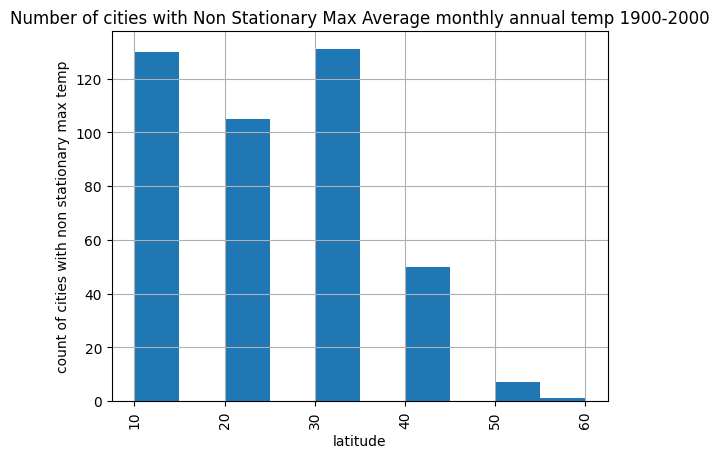

In [135]:
print("number of cities with non stationary max temp in ADF", len(non_stationary_full),"out of ",run_len,"cities")
def numlat(lat):
  outlatnum = ""
  for x in lat:
    if ((x != 'N') & (x != 'S')):
      outlatnum = outlatnum + x
  fl_outlatnum = float(outlatnum)  
  if ((fl_outlatnum > 0.0) & (fl_outlatnum <=10.0)):
    bin_outlatnum = 10.0
  if ((fl_outlatnum >10.0) & (fl_outlatnum <=20.0 )):  
    bin_outlatnum = 20.0 
  if ((fl_outlatnum >20.0) & (fl_outlatnum <=30.0 )):  
    bin_outlatnum = 30.0 
  if ((fl_outlatnum >30.0) & (fl_outlatnum <=40.0 )):  
    bin_outlatnum = 40.0 
  if ((fl_outlatnum >40.0) & (fl_outlatnum <=50.0 )):  
    bin_outlatnum = 50.0 
  if (fl_outlatnum >50.0  ):
    bin_outlatnum = 60.0 
  return bin_outlatnum
df_temp_city_nonstationary_full = pd.DataFrame(non_stationary_full)
df_temp_city_nonstationary_full= df_temp_city_nonstationary_full.rename(columns={df_temp_city_nonstationary_full.columns[0]:"country"})
df_temp_city_nonstationary_full= df_temp_city_nonstationary_full.rename(columns={df_temp_city_nonstationary_full.columns[1]:"city"})
df_temp_city_nonstationary_full= df_temp_city_nonstationary_full.rename(columns={df_temp_city_nonstationary_full.columns[2]:"latitude"})
df_temp_city_nonstationary_full= df_temp_city_nonstationary_full.rename(columns={df_temp_city_nonstationary_full.columns[3]:"longitude"})
df_temp_city_nonstationary_full.head()
df_temp_city_nonstationary_full= df_temp_city_nonstationary_full.assign(num_latitude= lambda x: x.latitude.apply(numlat))
df_temp_city_nonstationary_full.head()
df_nonstationary_summary = df_temp_city_nonstationary_full
hist = df_temp_city_nonstationary_full.num_latitude.hist()
plt.xlabel ("Latitude")
plt.xticks(rotation = 90)
plt.ylabel("Number of cities with non-stationary max temp")
plt.title( "Number of cities with non-stationary Max Average monthly annual temp 1900-2000")

It is clear from the Histogram, that cities with a `latitude` of less than 30 degrees constitute the bulk of the cities with a non-stationary maximum temperature. Closer to the poles, the effects of maximum temperature changes are mitigated. 
Based on the analysis of Philadelphia, it is possible to project that the maximum temperature is rising faster than the trend from 1900 to 2000. It is not meaningful to create a model averaging the maximum temperatures across a wide range of latitudes. The histogram above shows that the tropics are experiencing more change in temperature. 
Confirmatory analysis would need to focus on randomly chosen cities with non-stationary max temperatures.

# Model Comparison and Conclusion

* Linear regression (unregularized) showed an accuracy of 63%. This is under the assumption that there is no seasonality effect on temperature due to time and that there is simply a linear relationship between time and temperature.

* The Time Series analysis of the data shows that working with only average temperature may not reveal the extent of the change happening in the temperature. The analysis of maximum  monthly average temperature shows that this is non-stationary for over 50% of the cities. The detailed analysis of Philadelphia showed that the trend prediction using ARIMAX is still not accounting for all of the rise in maximum temperature. Taken together, these findings suggest that global maximum temperature is undergoing significant change.

# Potential Next Steps
* Given that we have temperature data of almost all countries, it would be interesting to have the GDP and other economic data of non-OECD countries to further see the relationship between climate and economy.
*  Additionally, including other economic data variables that are more granular in modelling might be considered. For instance, instead of just using population data, we can use population groups or the growth/shrinking index of the total population. Instead of using population density, we can use urbanized area data.
* It would be interesting to explore larger Disaster Tweets datasets (collected over a period of 1-2 years). We could potentially link the excessive tempatures to higher occurance of disaster events. That would allows us to make predictions about higher frequences of fires, floods, hurracanes, and other events.